In [ ]:
from pathlib import Path
import json, math
import numpy as np

# --- inputs ---
RX_POS_TXT = Path("../NeRAF/data/RAF/EmptyRoom/metadata/all_rx_pos.txt")
TX_POS_TXT = Path("../NeRAF/data/RAF/EmptyRoom/metadata/all_tx_pos.txt")
RUN_DIR_JSON = Path("./outputs/EmptyRoom/images-jpeg-1k/nerfacto/2025-11-04_172911/dataparser_transforms.json")

OUT_JSON = Path("camera_path.json")

# Viewer header
DEFAULT_FOV = 100.0
ASPECT = 1.5
RENDER_H, RENDER_W = 256,256
SECONDS = 999
IS_CYCLE = False
SMOOTHNESS = 0
CAMERA_TYPE = "perspective"

GLOBAL_UP = np.array([0.0, 0.0, 1.0], dtype=float)  # Z-up

# Control how many you keep
LIMIT = None     # None = all
STRIDE = 1       # keep every STRIDE-th pair (e.g., 5)

# ---------- helpers ----------
def float_no_sci(x, ndigits=12):
    s = f"{x:.{ndigits}f}"
    if "." in s:
        s = s.rstrip("0").rstrip(".")
        if s == "-0":
            s = "0"
        if "." not in s:
            s += ".0"
    return float(s)

def matrix_row_major_list(m4):
    return [float_no_sci(m4[i, j]) for i in range(4) for j in range(4)]

def load_dataparser_transform(run_dir_json):
    with open(run_dir_json, "r") as f:
        meta = json.load(f)
    T_3x4 = np.array(meta["transform"], dtype=float)  # (3,4)
    s = float(meta["scale"])
    R = T_3x4[:, :3]
    t = T_3x4[:, 3]
    return R, t, s

def normalize(v, eps=1e-9):
    n = np.linalg.norm(v)
    return v / n if n > eps else v * 0.0

def build_upright_look_at(cam_pos, target_pos, global_up=np.array([0,0,1.0])):
    f = normalize(target_pos - cam_pos)
    r = np.cross(global_up, f)
    if np.linalg.norm(r) < 1e-6:
        r = np.cross(np.array([1.0,0.0,0.0]), f)
        if np.linalg.norm(r) < 1e-6:
            r = np.array([0.0,1.0,0.0])
    r = normalize(r)
    u = np.cross(f, r)
    c2w = np.eye(4, dtype=float)
    c2w[:3, 0] = r
    c2w[:3, 1] = u
    c2w[:3, 2] = f
    c2w[:3, 3] = cam_pos
    return c2w

def parse_rx_all(path):
    """Yield RX positions: each line is y,z,x -> xyz; skip NaNs."""
    with open(path, "r") as f:
        for line in f:
            parts = [p.strip() for p in line.strip().split(",")]
            if len(parts) < 3: 
                continue
            try:
                y = float(parts[0]); z = float(parts[1]); x = float(parts[2])
            except ValueError:
                continue
            if all(math.isfinite(v) for v in (x,y,z)):
                yield np.array([x,y,z], dtype=float)

def parse_tx_all(path):
    """Yield TX quaternion (HypA yzxW -> xyzW) + TX position (yzx -> xyz)."""
    with open(path, "r") as f:
        for line in f:
            parts = [p.strip() for p in line.strip().split(",")]
            if len(parts) < 7:
                continue
            try:
                qy = float(parts[0]); qz = float(parts[1]); qx = float(parts[2]); qw = float(parts[3])  # yzxW
                py = float(parts[4]); pz = float(parts[5]); px = float(parts[6])                      # yzx
            except ValueError:
                continue
            if not all(math.isfinite(v) for v in (qx,qy,qz,qw,px,py,pz)):
                continue
            quat_xyzW = (qx, qy, qz, qw)
            pos_xyz   = np.array([px, py, pz], dtype=float)
            yield quat_xyzW, pos_xyz

def world_to_nerf_point(p_world, R, t, s):
    return s * (R @ p_world + t)

# ---------- main ----------
R_dp, t_dp, s_dp = load_dataparser_transform(RUN_DIR_JSON)

rx_iter = parse_rx_all(RX_POS_TXT)
tx_iter = parse_tx_all(TX_POS_TXT)

camera_entries = []
count_total = 0
count_kept = 0

for idx, (rx_p, tx_tuple) in enumerate(zip(rx_iter, tx_iter)):
    count_total += 1
    if idx % STRIDE != 0:
        continue
    _, tx_p = tx_tuple  # quat parsed but unused for upright mode
    # world -> NeRF
    rx_n = world_to_nerf_point(rx_p, R_dp, t_dp, s_dp)
    tx_n = world_to_nerf_point(tx_p, R_dp, t_dp, s_dp)
    # upright look-at
    c2w = build_upright_look_at(rx_n, tx_n, GLOBAL_UP)
    camera_entries.append({
        "camera_to_world": matrix_row_major_list(c2w),
        "fov": float_no_sci(DEFAULT_FOV),
        "aspect": float_no_sci(ASPECT),
    })
    count_kept += 1
    if LIMIT is not None and count_kept >= LIMIT:
        break

camera_path = {
    "default_fov": float_no_sci(DEFAULT_FOV),
    "default_transition_sec": 2,
    "camera_type": CAMERA_TYPE,
    "render_height": RENDER_H,
    "render_width": RENDER_W,
    "seconds": SECONDS,
    "is_cycle": IS_CYCLE,
    "smoothness_value": SMOOTHNESS,
    "camera_path": camera_entries,
}

with open(OUT_JSON, "w") as f:
    json.dump(camera_path, f, ensure_ascii=False, indent=2)

print(f"Wrote {OUT_JSON.resolve()} with {count_kept} / {count_total} paired cameras (stride={STRIDE}, limit={LIMIT}).")

Wrote /media/scratch/projects/labuser/msc_user/MoNezami/ReverbRAG/camera_path.json with 39132 / 39132 paired cameras (stride=1, limit=None).


In [23]:
import os, json, math, numpy as np, torch, torchaudio
from tqdm import tqdm

SCENE_ROOT = "../NeRAF/data/RAF/EmptyRoom"
DATA_DIR   = os.path.join(SCENE_ROOT, "data")
FEATS_DIR  = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)

# STFT params (RAF)
sr = 48000
n_fft, win_length, hop_length = 1024, 512, 256
T = 60
F = n_fft//2 + 1
DT_STFT = np.float16
MAX_SHARD_MB = 1024

stft_tf = torchaudio.transforms.Spectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    power=None, center=True, pad_mode="reflect"
)
def _logmag(x): return torch.log(x.abs() + 1e-3)

def _collect_sids(meta_json):
    with open(meta_json, "r") as f:
        splits = json.load(f)
    sids = []
    for v in splits.values():
        block = v[0] if (isinstance(v, list) and v and isinstance(v[0], list)) else v
        for sid in block:
            sids.append(f"{int(sid):06d}" if str(sid).isdigit() else str(sid))
    return sorted(set(sids))

def _load_wav(sid):
    p = os.path.join(DATA_DIR, sid, "rir.wav")
    wav, r = torchaudio.load(p)
    if r != sr: wav = torchaudio.functional.resample(wav, r, sr)
    wav = wav[:, : int(0.32 * sr)]
    return wav

def _stft60(wav):
    spec = stft_tf(wav)  # [1,F,T_full]
    if spec.shape[-1] > T:
        spec = spec[:, :, :T]
    elif spec.shape[-1] < T:
        minval = float(spec.abs().min())
        spec = torch.nn.functional.pad(spec, (0, T - spec.shape[-1]), value=minval)
    return _logmag(spec).squeeze(0)  # [F,T]

# Discover SIDs and (maybe) an existing index.json
SPLIT_JSON = os.path.join(SCENE_ROOT, "metadata", "data-split.json")
sids = _collect_sids(SPLIT_JSON)
idx_path = os.path.join(FEATS_DIR, "index.json")
index_meta = {"shards": [], "sid_to_ptr": {}}
if os.path.exists(idx_path):
    with open(idx_path, "r") as f:
        index_meta = json.load(f)

# Compute shard sizing
bytes_per_stft = F*T*np.dtype(DT_STFT).itemsize
items_per_shard = max(1, (MAX_SHARD_MB*1024*1024)//bytes_per_stft)
N = len(sids)
num_shards = math.ceil(N/items_per_shard)
print(f"[STFT] Items/shard≈{items_per_shard} → #shards={num_shards}")

def shard_paths(k):
    base = os.path.join(FEATS_DIR, f"shard_{k:03d}")
    return base+"_stft.npy"

# Build shards
for k in range(num_shards):
    start = k*items_per_shard
    end   = min(N, (k+1)*items_per_shard)
    n_k   = end - start
    st_p  = shard_paths(k)

    if os.path.exists(st_p):
        print(f"[STFT] shard {k} exists, skipping write.")
        st_mm = np.memmap(st_p, dtype=DT_STFT, mode="r+", shape=(n_k, F, T))
    else:
        print(f"[STFT] writing shard {k}: {n_k} items → {st_p}")
        st_mm = np.memmap(st_p, dtype=DT_STFT, mode="w+", shape=(n_k, F, T))

    for i, sid in tqdm(list(enumerate(sids[start:end], start=0)), total=n_k, desc=f"[STFT] {k+1}/{num_shards}"):
        if sid in index_meta["sid_to_ptr"]:
            continue
        x = _stft60(_load_wav(sid)).cpu().numpy().astype(DT_STFT)
        st_mm[i] = x
        index_meta["sid_to_ptr"][sid] = [k, i]
    del st_mm

# Write/merge index
# ensure one entry per shard with at least 'stft' path
existing = {sh["id"]: sh for sh in index_meta.get("shards", [])}
for k in range(num_shards):
    st_p = shard_paths(k)
    if k in existing:
        existing[k]["stft"] = st_p
        existing[k]["count"] = existing[k].get("count", 0) or sum(1 for v in index_meta["sid_to_ptr"].values() if v[0]==k)
        existing[k]["F"] = F; existing[k]["T"] = T
        existing[k].setdefault("dtypes", {})["stft"] = str(DT_STFT)
    else:
        existing[k] = {"id": k, "stft": st_p, "count": sum(1 for v in index_meta["sid_to_ptr"].values() if v[0]==k),
                       "F": F, "T": T, "dtypes": {"stft": str(DT_STFT)}}
index_meta["shards"] = [existing[k] for k in sorted(existing.keys())]

with open(idx_path, "w") as f:
    json.dump(index_meta, f)
print("[STFT] Done. Index saved to", idx_path)


[STFT] Items/shard≈17442 → #shards=3
[STFT] writing shard 0: 17442 items → ../NeRAF/data/RAF/EmptyRoom/feats/shard_000_stft.npy


[STFT] 1/3: 100%|██████████| 17442/17442 [01:08<00:00, 255.23it/s]


[STFT] writing shard 1: 17442 items → ../NeRAF/data/RAF/EmptyRoom/feats/shard_001_stft.npy


[STFT] 2/3: 100%|██████████| 17442/17442 [01:08<00:00, 253.44it/s]


[STFT] writing shard 2: 12600 items → ../NeRAF/data/RAF/EmptyRoom/feats/shard_002_stft.npy


[STFT] 3/3: 100%|██████████| 12600/12600 [00:48<00:00, 260.68it/s]


[STFT] Done. Index saved to ../NeRAF/data/RAF/EmptyRoom/feats/index.json


In [24]:
import os, json, numpy as np, torch, torchaudio
from tqdm import tqdm

SCENE_ROOT = "../NeRAF/data/RAF/EmptyRoom"
DATA_DIR   = os.path.join(SCENE_ROOT, "data")
FEATS_DIR  = os.path.join(SCENE_ROOT, "feats")
IDX_PATH   = os.path.join(FEATS_DIR, "index.json")

assert os.path.exists(IDX_PATH), "Missing feats/index.json — build STFT shards first."

# EDC settings
sr = 48000
T = 60
DT_EDC = np.float32

def _load_wav(sid):
    p = os.path.join(DATA_DIR, sid, "rir.wav")
    wav, r = torchaudio.load(p)
    if r != sr: wav = torchaudio.functional.resample(wav, r, sr)
    return wav.squeeze(0)[: int(0.32 * sr)]  # [S]

def _edc_db_60(w1d):
    e = (w1d.float()**2)
    edc = torch.flip(torch.cumsum(torch.flip(e, [0]), 0), [0])
    edc = edc / (edc[0] + 1e-12)
    edc_db = 10*torch.log10(edc + 1e-12)
    idx = torch.linspace(0, edc_db.numel()-1, steps=T).long()
    return edc_db[idx]  # [T]

with open(IDX_PATH, "r") as f:
    idx = json.load(f)

sid_to_ptr = {k: tuple(v) for k, v in idx["sid_to_ptr"].items()}
# Gather SIDs per shard using the EXISTING mapping
shard_to_sidrows = {}
for sid, (k, row) in sid_to_ptr.items():
    shard_to_sidrows.setdefault(k, []).append((sid, row))

# Build/overwrite EDC shard files using the STFT shard counts
for sh in idx["shards"]:
    k = sh["id"]
    count = int(sh["count"])
    edc_path = os.path.join(FEATS_DIR, f"shard_{k:03d}_edc.npy")

    # Create memmap with shape matching the STFT shard
    ed_mm = np.memmap(edc_path, dtype=DT_EDC, mode="w+", shape=(count, T))
    rows = shard_to_sidrows.get(k, [])
    print(f"[EDC] shard {k}: writing {len(rows)} rows into {count}-row memmap -> {edc_path}")

    for sid, row in tqdm(rows, total=len(rows), desc=f"[EDC] {k:03d}"):
        # guard: row must be < count (if not, your index.json is already inconsistent with STFT shards)
        if not (0 <= row < count):
            raise RuntimeError(f"Index mismatch: SID {sid} maps to row {row} but shard {k} has count {count}")
        w = _load_wav(sid)
        ed_mm[row] = _edc_db_60(w).cpu().numpy().astype(DT_EDC)

    del ed_mm

    # annotate shard record with EDC path & dtype
    sh["edc"] = edc_path
    sh.setdefault("dtypes", {})["edc"] = str(DT_EDC)

with open(IDX_PATH, "w") as f:
    json.dump(idx, f)

print("[EDC] Repair complete. index.json updated.")


[EDC] shard 0: writing 17442 rows into 17442-row memmap -> ../NeRAF/data/RAF/EmptyRoom/feats/shard_000_edc.npy


[EDC] 000: 100%|██████████| 17442/17442 [00:33<00:00, 523.85it/s]


[EDC] shard 1: writing 17442 rows into 17442-row memmap -> ../NeRAF/data/RAF/EmptyRoom/feats/shard_001_edc.npy


[EDC] 001: 100%|██████████| 17442/17442 [00:35<00:00, 491.62it/s]


[EDC] shard 2: writing 12600 rows into 12600-row memmap -> ../NeRAF/data/RAF/EmptyRoom/feats/shard_002_edc.npy


[EDC] 002: 100%|██████████| 12600/12600 [00:24<00:00, 510.68it/s]


[EDC] Repair complete. index.json updated.


In [23]:
# CELL 1 — Global cache (fast):
#   • EDC via precomputed curves + broadcast distances (L1/L2, globally consistent)
#   • SPL via GPU hub (compute_audio_distance)
#   • Decays (T60/EDT/C50/DR) via one-shot scalars + broadcasting
#
# Saves: ./dist_cache/{METRIC}.npz with RAW & global-Z matrices aligned across metrics

import os, sys, glob, json, math
import numpy as np
import torch
from tqdm.auto import tqdm

# ---------------- KNOBS ----------------
SCENE_ROOT      = "../NeRAF/data/RAF/FurnishedRoom"                      # adjust
RENDERS_GLOB    = "../NeRAF/eval_results/furnishedroom/renders/eval_*.npy"
K_QUERIES       = 20                   # first K renders as queries
REF_SPLIT_TRY   = "reference"        # fallback to "train" if missing
DEVICE          = "cuda" if torch.cuda.is_available() else "cpu"

# Which metrics to compute/cache
METRICS = ["EDC", "SPL", "T60", "EDT", "C50", "DR"]

# EDC options (to mimic your hub normalization by default)
EVAL_FS         = 48000
EDC_BINS        = 60                 # fixed bins for all signals
EDC_ANCHOR_ZERO = True               # subtract first bin (0 dB at start)
EDC_ZSCORE      = True               # per-curve z-score after anchoring
EDC_DIST_MODE   = "l1"               # choose "l1" or "l2"
# scale normalization for distances so magnitudes are comparable
EDC_L2_SCALE    = "sqrtN"            # "sqrtN" -> divide by sqrt(EDC_BINS); None to disable
EDC_L1_SCALE    = "mean"             # "mean"  -> divide by N; None to disable

# GPU chunking over references (for SPL only)
REF_BATCH       = 2048

# Save dir
DIST_CACHE_DIR  = "./dist_cache"

# ---------------------------------------
# Project imports
sys.path.append(".")
sys.path.append("/mnt/data")
from evaluator import compute_audio_distance, compute_edc_db
try:
    from evaluator import compute_t60, evaluate_edt, evaluate_clarity
    HAVE_DECAY_HELPERS = True
except Exception:
    HAVE_DECAY_HELPERS = False

try:
    from data import RAFDataset
except Exception:
    raise RuntimeError("Cannot import RAFDataset; fix sys.path to your repo.")

# ---------- Utils ----------
def _ensure_dir(p): os.makedirs(p, exist_ok=True)

def _global_z(M: np.ndarray):
    m = np.isfinite(M)
    if not m.any():
        mu, sd = 0.0, 1.0
        Z = np.zeros_like(M, dtype=np.float32)
    else:
        mu = float(np.mean(M[m]))
        sd = float(np.std(M[m]) + 1e-6)
        Z = (M - mu) / sd
        Z[~np.isfinite(Z)] = 0.0
    return Z.astype(np.float32), float(mu), float(sd)

@torch.no_grad()
def _pad_batch_1d(wavs_list, device, dtype=torch.float32):
    if len(wavs_list) == 0:
        return torch.zeros(0, 1, dtype=dtype, device=device)
    Tmax = max(int(w.numel()) for w in wavs_list)
    out = torch.zeros(len(wavs_list), Tmax, dtype=dtype, device=device)
    for i, w in enumerate(wavs_list):
        t = int(w.numel())
        out[i, :t] = w.to(device=device, dtype=dtype)
    return out

def _dr_db(x_1d_np: np.ndarray) -> float:
    rms = np.sqrt(np.mean(x_1d_np**2) + 1e-12)
    peak = np.max(np.abs(x_1d_np)) + 1e-12
    return float(20.0 * np.log10(peak / max(rms, 1e-12)))

# ---------- Scan renders (queries) ----------
render_files = sorted(glob.glob(RENDErs_GLOB := RENDERS_GLOB))
assert len(render_files) > 0, f"No NPY renders found at: {RENDErs_GLOB}"
if K_QUERIES is not None:
    render_files = render_files[:int(K_QUERIES)]
query_ids = [os.path.basename(fp) for fp in render_files]
Q = len(query_ids)
print(f"[info] Queries (K) = {Q}")

# ---------- Reference bank ----------
try:
    ds_ref = RAFDataset(scene_root=SCENE_ROOT, split=REF_SPLIT_TRY,
                        model_kind="neraf", sample_rate=EVAL_FS, dataset_mode="full")
    ref_split_name = REF_SPLIT_TRY
except Exception as e:
    print(f"[warn] '{REF_SPLIT_TRY}' split missing ({e}); using 'train' as reference bank.")
    ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train",
                        model_kind="neraf", sample_rate=EVAL_FS, dataset_mode="full")
    ref_split_name = "train"

ref_ids    = list(ds_ref.ids)
id2idx_ref = ds_ref.id2idx
R = len(ref_ids)
print(f"[info] Reference bank: split='{ref_split_name}' | #items={R}")

# ---------- Preload references (CPU) ----------
REF_STFTS, REF_WAVS = [], []
for sid in tqdm(ref_ids, desc="Load refs", unit="ref"):
    it = ds_ref[id2idx_ref[sid]]
    REF_STFTS.append(it["stft"].squeeze(0).contiguous())  # [F,60]
    REF_WAVS.append(it["wav"].squeeze(0).contiguous())    # [T]
F, T = REF_STFTS[0].shape
print(f"[info] Reference STFT grid: F={F}, T={T}")

# ---------- Load queries (CPU) ----------
Q_STFTS, Q_WAVS = [], []
for fp in tqdm(render_files, desc="Load queries", unit="file"):
    pack = np.load(fp, allow_pickle=True).item()
    Q_STFTS.append(torch.from_numpy(pack["data"]).float().squeeze(0).contiguous())      # [F,60] GT
    Q_WAVS.append(torch.from_numpy(pack["waveform"]).float().squeeze(0).contiguous())   # [T]

# ---------- EDC CURVES: compute ONCE for all signals ----------
@torch.no_grad()
def _edc_curve(wav_1d: torch.Tensor, bins: int = EDC_BINS) -> torch.Tensor:
    # compute_edc_db returns shape [T_edc]; we fix T_edc=bins for consistency
    return compute_edc_db(wav_1d.float(), T_target=bins)  # on current device of wav_1d

def _normalize_edc_curves(mat: np.ndarray) -> np.ndarray:
    # mat: (N, BINS), in dB
    X = mat.copy()
    if EDC_ANCHOR_ZERO:
        X = X - X[:, :1]   # anchor at 0 dB at start
    if EDC_ZSCORE:
        mu = X.mean(axis=1, keepdims=True)
        sd = X.std(axis=1, keepdims=True) + 1e-6
        X = (X - mu) / sd
    return X.astype(np.float32)

def _edc_scalers():
    # Return scaling factor for distances to make magnitudes comparable
    if EDC_DIST_MODE.lower() == "l2":
        if EDC_L2_SCALE == "sqrtN":
            return 1.0 / math.sqrt(EDC_BINS)
        return 1.0
    elif EDC_DIST_MODE.lower() == "l1":
        if EDC_L1_SCALE == "mean":
            return 1.0 / float(EDC_BINS)
        return 1.0
    else:
        raise ValueError("EDC_DIST_MODE must be 'l1' or 'l2'")

print("\n[edc] Computing EDC curves for queries & refs (once each) ...")
Q_EDC = np.zeros((Q, EDC_BINS), dtype=np.float32)
for i, w in enumerate(tqdm(Q_WAVS, desc="EDC(Q)", unit="q")):
    edc = _edc_curve(w.to(DEVICE)).detach().cpu().numpy()
    Q_EDC[i, :] = edc

R_EDC = np.zeros((R, EDC_BINS), dtype=np.float32)
for j, w in enumerate(tqdm(REF_WAVS, desc="EDC(R)", unit="ref")):
    edc = _edc_curve(w.to(DEVICE)).detach().cpu().numpy()
    R_EDC[j, :] = edc

# Normalize per-curve (mimic hub path)
Q_EDC = _normalize_edc_curves(Q_EDC)  # (Q,B)
R_EDC = _normalize_edc_curves(R_EDC)  # (R,B)

# ---------- DECAY SCALARS: compute ONCE ----------
def _decay_scalars_for_wavs(wavs_list, tag):
    if not HAVE_DECAY_HELPERS:
        raise RuntimeError("Decay helpers missing in evaluator.py; cannot compute T60/EDT/C50/DR.")
    out = np.zeros((len(wavs_list), 4), dtype=np.float32)
    for i, w in enumerate(tqdm(wavs_list, desc=f"Decays({tag})", unit="wav")):
        w_np = w.detach().cpu().numpy()[None, :]
        t60, _ = compute_t60(w_np, w_np, fs=EVAL_FS, advanced=True)
        edt, _ = evaluate_edt(w_np, w_np, fs=EVAL_FS)
        c50, _ = evaluate_clarity(w_np, w_np, fs=EVAL_FS)
        t60 = float(np.atleast_1d(t60)[0]); edt = float(np.atleast_1d(edt)[0]); c50 = float(np.atleast_1d(c50)[0])
        dr = _dr_db(w.detach().cpu().numpy())
        out[i, :] = [t60, c50, edt, dr]
    return out  # (N,4)

DEC_Q = _decay_scalars_for_wavs(Q_WAVS, tag="Q")   # (Q,4)
DEC_R = _decay_scalars_for_wavs(REF_WAVS, tag="R") # (R,4)

# ---------- helper: save a matrix with global-Z ----------
def _save_matrix(metric_name: str, M: np.ndarray, meta_base: dict):
    Z, mu, sd = _global_z(M)
    os.makedirs(DIST_CACHE_DIR, exist_ok=True)
    path = os.path.join(DIST_CACHE_DIR, f"{metric_name}.npz")
    meta = {
        **meta_base, "metric": metric_name, "global_mu": mu, "global_sd": sd,
        "edc": {
            "bins": EDC_BINS, "anchor0": EDC_ANCHOR_ZERO, "zscore": EDC_ZSCORE,
            "dist_mode": EDC_DIST_MODE, "l2_scale": EDC_L2_SCALE, "l1_scale": EDC_L1_SCALE
        } if metric_name == "EDC" else None
    }
    np.savez_compressed(
        path,
        Z=Z.astype(np.float32),
        RAW=M.astype(np.float32),
        query_ids=np.array(query_ids, dtype=object),
        ref_ids=np.array(ref_ids, dtype=object),
        meta=json.dumps(meta)
    )
    print(f"[saved] {metric_name}: {path} | mu={mu:.6f} sd={sd:.6f}")

# ---------- META ----------
meta = {
    "scene_root": SCENE_ROOT,
    "renders_glob": RENDERS_GLOB,
    "fs": EVAL_FS,
    "ref_split": ref_split_name,
    "device": DEVICE,
    "notes": ("Rows=first K npys, Cols=all refs. RAW + global-Z. "
              "EDC via per-signal curves + broadcast distances; "
              "SPL via compute_audio_distance; Decays via broadcasted |ref-query|.")
}

# ---------- EDC matrix (K,R) via broadcasting over precomputed curves ----------
if "EDC" in METRICS:
    print(f"\n[metric] EDC({EDC_DIST_MODE.upper()}): broadcasting (K={Q}, R={R}, B={EDC_BINS}) ...")
    scale = _edc_scalers()

    # Q_EDC: (Q,B), R_EDC: (R,B) —> pairwise distances (Q,R)
    # Use memory-efficient trick: process refs in chunks if RAM is tight
    M = np.zeros((Q, R), dtype=np.float32)
    CH = max(1, 131072 // EDC_BINS)  # rough chunking heuristic to bound RAM
    for start in range(0, R, CH):
        end = min(start + CH, R)
        Rblk = R_EDC[start:end, :]                 # (b,B)
        # Expand and compute |Q[:,None,:] - Rblk[None,:,:]|
        diff = Q_EDC[:, None, :] - Rblk[None, :, :]   # (Q,b,B)
        if EDC_DIST_MODE.lower() == "l2":
            d = np.linalg.norm(diff, axis=2)          # (Q,b)
            if EDC_L2_SCALE == "sqrtN":
                d = d * scale
        elif EDC_DIST_MODE.lower() == "l1":
            d = np.sum(np.abs(diff), axis=2)          # (Q,b)
            if EDC_L1_SCALE == "mean":
                d = d * scale
        else:
            raise ValueError("EDC_DIST_MODE must be 'l1' or 'l2'")
        M[:, start:end] = d.astype(np.float32)

    _save_matrix("EDC", M, meta)

# ---------- SPL matrix (K,R) via GPU hub ----------
if "SPL" in METRICS:
    print(f"\n[metric] SPL: computing (K={Q}, R={R}) via hub ...")
    M = np.zeros((Q, R), dtype=np.float32)
    for qi in tqdm(range(Q), desc="SPL per-query", unit="q"):
        q_stft = Q_STFTS[qi].to(DEVICE, non_blocking=True)
        row_parts = []
        for start in range(0, R, REF_BATCH):
            end = min(start + REF_BATCH, R)
            ref_stfts_b = torch.stack(REF_STFTS[start:end], dim=0).to(DEVICE, non_blocking=True) # [B,F,T]
            stft_blk = torch.cat([q_stft.unsqueeze(0), ref_stfts_b], dim=0)                       # [1+B,F,T]
            with torch.no_grad():
                D = compute_audio_distance(stft_blk, wavs=None, edc_curves=None,
                                           decay_feats=None, metric="SPL", fs=EVAL_FS)
            row_parts.append(D[0, 1:].detach().cpu().numpy())
            del ref_stfts_b, stft_blk, D
            torch.cuda.empty_cache()
        M[qi, :] = np.concatenate(row_parts, axis=0)
    _save_matrix("SPL", M, meta)

# ---------- Decay matrices (K,R) via broadcasted |ref - query| ----------
col = {"T60":0, "C50":1, "EDT":2, "DR":3}
for m in ["T60","EDT","C50","DR"]:
    if m not in METRICS: continue
    print(f"\n[metric] {m}: broadcasting (K={Q}, R={R}) ...")
    qi = DEC_Q[:, col[m]].reshape(Q, 1)     # (Q,1)
    rj = DEC_R[:, col[m]].reshape(1, R)     # (1,R)
    M = np.abs(rj - qi)                      # (Q,R)
    _save_matrix(m, M, meta)

print("\n[done] All requested metrics cached globally in ./dist_cache/")


[info] Queries (K) = 20
[info] Reference bank: split='reference' | #items=20000


Load refs:   0%|          | 0/20000 [00:00<?, ?ref/s]

[info] Reference STFT grid: F=513, T=60


Load queries:   0%|          | 0/20 [00:00<?, ?file/s]


[edc] Computing EDC curves for queries & refs (once each) ...


EDC(Q):   0%|          | 0/20 [00:00<?, ?q/s]

EDC(R):   0%|          | 0/20000 [00:00<?, ?ref/s]

Decays(Q):   0%|          | 0/20 [00:00<?, ?wav/s]

Decays(R):   0%|          | 0/20000 [00:00<?, ?wav/s]


[metric] EDC(L1): broadcasting (K=20, R=20000, B=60) ...
[saved] EDC: ./dist_cache/EDC.npz | mu=0.141915 sd=0.065945

[metric] SPL: computing (K=20, R=20000) via hub ...


SPL per-query:   0%|          | 0/20 [00:00<?, ?q/s]

[saved] SPL: ./dist_cache/SPL.npz | mu=0.587531 sd=0.340065

[metric] T60: broadcasting (K=20, R=20000) ...
[saved] T60: ./dist_cache/T60.npz | mu=0.169088 sd=0.135457

[metric] EDT: broadcasting (K=20, R=20000) ...
[saved] EDT: ./dist_cache/EDT.npz | mu=0.256786 sd=0.219765

[metric] C50: broadcasting (K=20, R=20000) ...
[saved] C50: ./dist_cache/C50.npz | mu=8.121808 sd=6.199946

[metric] DR: broadcasting (K=20, R=20000) ...
[saved] DR: ./dist_cache/DR.npz | mu=5.458077 sd=4.075886

[done] All requested metrics cached globally in ./dist_cache/


In [ ]:
# CELL 2 — Mix cached global-z metrics (first K queries), lazy-evaluate Top-k only
# --------------------------------------------------------------------------------
# - Loads ./dist_cache/*.npz built by Cell 1
# - Restricts to first K queries (same K used in Cell 1)
# - Combines any subset of metrics with normalized weights
# - Retrieves Top-k per query
# - Optional: fast evaluation summary that loads ONLY the Top-k refs (lazy), not all refs

import os, sys, glob, json, math
import numpy as np
import torch
from tqdm.auto import tqdm

# ---------------- KNOBS ----------------
CACHE_DIR       = "./dist_cache"

# Choose any subset and weights (renormalized to sum=1 over the active subset present on disk)
WEIGHTS         = {
    "EDC": 0.6,
    "SPL": 0.4,
    # "T60": 0.0,
    # "EDT": 0.0,
    # "C50": 0.0,
    # "DR":  0.0,
}

TOPK            = 3
DO_EVAL_SUMMARY = True      # set False to skip evaluator (just prints indices)

# IMPORTANT: limit to first K queries (same K used in Cell 1). None => use full cache size.
K_LIMIT         = 20

# ---------------------------------------
# Repo imports for evaluation only
sys.path.append(".")
sys.path.append("/mnt/data")
from evaluator import UnifiedEvaluator
try:
    from data import RAFDataset
except Exception:
    raise RuntimeError("Cannot import RAFDataset; adjust sys.path to your repo.")

def _load_metric(name: str):
    path = os.path.join(CACHE_DIR, f"{name}.npz")
    if not os.path.exists(path):
        return None
    pack = np.load(path, allow_pickle=True)
    Z = pack["Z"].astype(np.float32)                     # (Q,R)
    query_ids = list(pack["query_ids"])
    ref_ids   = list(pack["ref_ids"])
    meta = json.loads(str(pack["meta"]))
    return {"Z": Z, "query_ids": query_ids, "ref_ids": ref_ids, "meta": meta}

# ---- Resolve active metrics present on disk with positive weight
candidates = [m for m,w in WEIGHTS.items() if w > 0.0]
present = [m for m in candidates if os.path.exists(os.path.join(CACHE_DIR, f"{m}.npz"))]
assert len(present) > 0, f"No active metrics available in {CACHE_DIR} for weights={candidates}"

root = _load_metric(present[0])
Z0, query_ids_cache, ref_ids_cache, meta0 = root["Z"], root["query_ids"], root["ref_ids"], root["meta"]
Q_full, R = Z0.shape

# ---- Enforce K_LIMIT consistently (rows of all matrices)
if K_LIMIT is None:
    K = Q_full
else:
    K = int(min(K_LIMIT, Q_full))

# Slice helper for matrices and query id list
def _take_first_k_rows(M): return M[:K, :] if M.shape[0] >= K else M
query_ids = query_ids_cache[:K]

# Load remaining matrices and align
MATS = {present[0]: _take_first_k_rows(Z0)}
for m in present[1:]:
    dat = _load_metric(m)
    assert dat is not None, f"{m} vanished from cache."
    # Consistency checks (ordering must be identical across metrics)
    assert dat["ref_ids"] == ref_ids_cache, f"ref_ids mismatch between metrics ({present[0]} vs {m})"
    assert dat["query_ids"] == query_ids_cache, f"query_ids mismatch between metrics ({present[0]} vs {m})"
    MATS[m] = _take_first_k_rows(dat["Z"])

# Combine with normalized weights over the 'present' keys
ws = np.array([WEIGHTS[m] for m in present], dtype=np.float64)
ws = ws / (ws.sum() + 1e-12)

COMB = np.zeros((K, R), dtype=np.float32)
for i, m in enumerate(present):
    COMB += float(ws[i]) * MATS[m]

# ---- Top-k per query (smallest scores)
topk_indices = []
topk_ids     = []
for qi in range(K):
    idx = np.argpartition(COMB[qi], TOPK)[:TOPK]
    idx = idx[np.argsort(COMB[qi, idx])]  # stable sort of the k smallest
    topk_indices.append(idx.tolist())
    topk_ids.append([ref_ids_cache[j] for j in idx.tolist()])

print(f"Active metrics (global-z): {present} | weights={ws.round(6).tolist()}")
for qi in range(K):
    print(f"[q={query_ids[qi]}] TOP{TOPK}: {topk_ids[qi]}  scores={[float(COMB[qi,j]) for j in topk_indices[qi]]}")

# ---------------- Optional: evaluation summary (Baseline vs Top-k) ----------------
if DO_EVAL_SUMMARY:
    # Pull scene_root and renders_glob from cache meta to avoid mismatches with Cell 1
    SCENE_ROOT   = meta0.get("scene_root", "../NeRAF/data/RAF/FurnishedRoom")
    RENDERS_GLOB = meta0.get("renders_glob", "../NeRAF/eval_results/furnishedroom/renders/eval_*.npy")
    EVAL_FS      = int(meta0.get("fs", 48000))
    DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

    # Build a lookup from filename to full path using the glob from cache meta
    render_all = sorted(glob.glob(RENDEERS_GLOB := RENDERS_GLOB))  # store str for messages
    name2path = {os.path.basename(p): p for p in render_all}

    # Use EXACT same first-K filenames from cache (fallback to position-based if missing)
    render_files = []
    for nm in query_ids:
        if nm in name2path:
            render_files.append(name2path[nm])
        else:
            print(f"[warn] {nm} not found under {RENDEERS_GLOB}; falling back to glob order.")
    if len(render_files) < K:
        render_files = sorted(glob.glob(RENDEERS_GLOB))[:K]

    # ===== SPEED FIX: only load the references we actually need (Top-k set) =====
    needed_ref_idx = sorted(set(j for row in topk_indices for j in row))  # unique global indices
    idxmap = {j:i for i,j in enumerate(needed_ref_idx)}  # map global gidx -> compact 0..M-1
    print(f"[info] Will load only {len(needed_ref_idx)} referenced STFTs out of R={R}.")

    ds_ref = RAFDataset(scene_root=SCENE_ROOT, split=meta0.get("ref_split","reference"),
                        model_kind="neraf", sample_rate=EVAL_FS, dataset_mode="full")
    id2idx_ref = ds_ref.id2idx

    # Load STFTs just for needed refs (CPU, lazily)
    SMALL_REF_STFTS = {}
    for gidx in tqdm(needed_ref_idx, desc="Load Top-k refs", unit="ref"):
        sid = ref_ids_cache[gidx]
        it = ds_ref[id2idx_ref[sid]]
        SMALL_REF_STFTS[gidx] = it["stft"].squeeze(0).contiguous()

    evaluator = UnifiedEvaluator(fs=EVAL_FS, edc_bins=60, edc_dist="l2")

    agg_keys = ["stft","edc","t60","edt","c50"]
    def _zero_agg():
        return {k:[0.0,0] for k in (
            ["base_"+x for x in agg_keys] +
            sum([[f"t{i}_{x}", f"d{i}_{x}"] for i in (1,2,3) for x in agg_keys], [])
        )}

    def _add(agg, k, v):
        vv = float(v)
        if math.isfinite(vv):
            agg[k][0] += vv; agg[k][1] += 1

    def _mean(pair): s,n = pair; return (s/max(n,1)) if n>0 else float("nan")

    @torch.no_grad()
    def _eval_pair(stft_a_2d, stft_b_2d):
        return evaluator.evaluate(
            stft_a_2d.view(1,1,*stft_a_2d.shape).to(DEVICE),
            stft_b_2d.view(1,1,*stft_b_2d.shape).to(DEVICE)
        )

    # Evaluate baseline and only Top-k refs
    agg = _zero_agg()
    for qi, fp in enumerate(tqdm(render_files[:K], desc="Eval summary", unit="q")):
        pack = np.load(fp, allow_pickle=True).item()
        stft_gt  = torch.from_numpy(pack["data"]).float().squeeze(0)
        stft_pr  = torch.from_numpy(pack["pred_stft"]).float().squeeze(0)

        base = _eval_pair(stft_pr, stft_gt)
        for k in agg_keys: _add(agg, f"base_{k}", base[k])

        # Top-k from combined matrix (already aligned to cache ref_ids)
        sel = topk_indices[qi]
        for rank, tag in enumerate(("t1","t2","t3"), start=1):
            if len(sel) < rank: continue
            gidx = sel[rank-1]
            ref_st = SMALL_REF_STFTS[gidx].to(DEVICE)
            top = _eval_pair(ref_st, stft_gt)
            for k in agg_keys:
                _add(agg, f"{tag}_{k}", top[k])
                _add(agg, f"d{rank}_{k}", float(top[k]-base[k]))

    # Print compact summary
    print("\n===== SUMMARY (means over processed files) =====")
    print(f"Files processed: {K} | Reference pool: {R} | Active metrics: {present}")
    print(f"{'':12s}{'stft':>10s}{'edc':>10s}{'t60':>10s}{'edt':>10s}{'c50':>10s}")

    def _line(title, keys):
        vals = [_mean(agg[k]) for k in keys]
        print(f"{title:<12s}" + "".join([f"{v:10.6f}" for v in vals]))

    _line("Baseline",  [f"base_{k}" for k in agg_keys])
    for r, tag in enumerate(("t1","t2","t3"), start=1):
        _line(f"Top{r}",       [f"{tag}_{k}" for k in agg_keys])
        _line(f"ΔTop{r}-Base", [f"d{r}_{k}"  for k in agg_keys])
    print()


Active metrics (global-z): ['EDC', 'SPL'] | weights=[0.6, 0.4]
[q=eval_000000.npy] TOP3: ['036096', '036106', '036105']  scores=[-1.6228878498077393, -1.5719029903411865, -1.551689624786377]
[q=eval_000001.npy] TOP3: ['036438', '036441', '036443']  scores=[-1.5854880809783936, -1.525365948677063, -1.5044968128204346]
[q=eval_000002.npy] TOP3: ['029754', '029744', '029737']  scores=[-1.611403465270996, -1.5437387228012085, -1.472914218902588]
[q=eval_000003.npy] TOP3: ['010023', '027124', '019589']  scores=[-1.394456386566162, -1.3839342594146729, -1.3662970066070557]
[q=eval_000004.npy] TOP3: ['033850', '033871', '033873']  scores=[-1.6325452327728271, -1.5399271249771118, -1.5194473266601562]
[info] Will load only 15 referenced STFTs out of R=20000.


Load Top-k refs:   0%|          | 0/15 [00:00<?, ?ref/s]

Eval summary:   0%|          | 0/5 [00:00<?, ?q/s]


===== SUMMARY (means over processed files) =====
Files processed: 5 | Reference pool: 20000 | Active metrics: ['EDC', 'SPL']
                  stft       edc       t60       edt       c50
Baseline      0.170139  0.118459  8.222797  0.034875  0.358303
Top1          0.213854  0.064593  3.754443  0.019775  0.255973
ΔTop1-Base    0.043714 -0.053866 -4.468353 -0.015100 -0.102330
Top2          0.213429  0.077529  3.190934  0.031950  0.619630
ΔTop2-Base    0.043290 -0.040930 -5.031863 -0.002925  0.261327
Top3          0.217224  0.112896  5.471308  0.030350  0.463162
ΔTop3-Base    0.047085 -0.005563 -2.751488 -0.004525  0.104859



In [ ]:
# === CELL 1: Build per-metric distance caches (Numba + tqdm + chunking) ===
import os, glob, json, math, numpy as np, torch, numba
from tqdm import tqdm
from data import RAFDataset

# ---------------- KNOBS ----------------
SCENE_ROOT  = "../NeRAF/data/RAF/FurnishedRoom"
RENDS_GLOB  = "../NeRAF/eval_results/furnishedroom/renders/eval_*.npy"
REF_SPLIT   = "reference"       # reference bank
K_QUERIES   = 50            # first-K npy files; -1 => use all
EDC_BINS    = 60
DIST_DIR    = "./dist_cache"
os.makedirs(DIST_DIR, exist_ok=True)

# Chunk sizes for progress + lower peak RAM (tune if needed)
Q_CHUNK = 64     # rows per chunk (queries)
R_CHUNK = None   # keep None (we compute vs. all refs per q-chunk); set to int for 2D tiling if memory is tight

# ---------------- Numba kernels ----------------
@numba.njit(fastmath=True)
def _zscore_rowwise(M):
    Q,R = M.shape
    Z = np.empty_like(M)
    for i in range(Q):
        mu = np.mean(M[i]); sd = np.std(M[i]) + 1e-12
        Z[i] = (M[i] - mu) / sd
    return Z

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        for j in range(R):
            D[i, j] = np.sum(np.abs(A[i] - B[j]))
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        for j in range(R):
            diff = A[i] - B[j]
            D[i, j] = math.sqrt(np.sum(diff * diff))
    return D

@numba.njit(fastmath=True)
def _edc_db(wav, bins=60):
    e = wav * wav
    edc = np.cumsum(e[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    edc_db = 10.0 * np.log10(edc + 1e-12)
    idx = np.linspace(0, edc_db.size - 1, bins).astype(np.int64)
    return edc_db[idx]

@numba.njit(fastmath=True)
def _decay_from_edc(edc_db):
    # EDT via -10 dB crossing, T60 via -60 dB crossing (fallbacks if not reached)
    n = edc_db.size; s0 = edc_db[0]
    edt_f = -1; t60_f = -1
    for i in range(n):
        drop = s0 - edc_db[i]
        if edt_f < 0 and drop >= 10.0: edt_f = i
        if t60_f < 0 and drop >= 60.0:
            t60_f = i; break
    if t60_f < 0: t60_f = n
    if edt_f < 0: edt_f = min(n, int(t60_f / 6))
    edc_lin = 10.0 ** (edc_db / 10.0)
    split = n // 12  # crude ~50ms if ~0.32s total at 60 bins
    c50_db = 10.0 * np.log10((np.sum(edc_lin[:split]) + 1e-12) / (np.sum(edc_lin[split:]) + 1e-12))
    dr_db = 10.0 * np.log10((np.max(edc_lin) + 1e-12) / (np.mean(edc_lin) + 1e-12))
    # return T60 (frames), EDT (~ms proxy via *6), C50 (dB), DR (dB)
    return float(t60_f), float(edt_f * 6), float(c50_db), float(dr_db)

@numba.njit(parallel=True, fastmath=True)
def _batch_edc_decay(wavs, bins=60):
    N = wavs.shape[0]
    E = np.empty((N, bins), np.float64)
    D = np.empty((N, 4),   np.float64)  # T60, EDT, C50, DR
    for i in numba.prange(N):
        edc = _edc_db(wavs[i], bins)
        E[i] = edc
        t60, edt, c50, dr = _decay_from_edc(edc)
        D[i, 0] = t60; D[i, 1] = edt; D[i, 2] = c50; D[i, 3] = dr
    return E, D

def _save_small(name, Z, qids, rids):
    out = {
        "Z": Z.astype(np.float32),
        "query_ids": np.array(qids, dtype=object),
        "ref_ids":   np.array(rids, dtype=object),
        "meta": json.dumps({"metric": name, "norm": "row_zscore",
                            "bins": EDC_BINS, "K": int(Z.shape[0]), "R": int(Z.shape[1])})
    }
    path = os.path.join(DIST_DIR, f"{name}.npz")
    np.savez_compressed(path, **out)
    print(f"[saved] {name:8s} -> {path} | shape={Z.shape}")

def _iter_chunks(n, chunk):
    if chunk is None or chunk >= n:
        yield 0, n
    else:
        for s in range(0, n, chunk):
            e = min(s + chunk, n)
            yield s, e

# ---------------- Load queries/refs ----------------
files_all = sorted(glob.glob(RENDS_GLOB))
assert files_all, f"No npy renders under {RENDS_GLOB}"
files = files_all if (K_QUERIES is None or K_QUERIES <= 0) else files_all[:K_QUERIES]
query_ids = [os.path.basename(f) for f in files]

Q_STFT, Q_WAV = [], []
for f in tqdm(files, desc="Load queries"):
    d = np.load(f, allow_pickle=True).item()
    # If your npy keys differ, adjust here
    q_stft = torch.from_numpy(d["data"]).float().squeeze(0).numpy().astype(np.float64)
    q_wav  = torch.from_numpy(d["waveform"]).float().squeeze(0).numpy().astype(np.float64)
    Q_STFT.append(q_stft)
    Q_WAV.append(q_wav)
Q_STFT = np.stack(Q_STFT)                         # (K, F, T)
Q_WAV  = np.stack(Q_WAV)                          # (K, Tw)

ds_ref = RAFDataset(scene_root=SCENE_ROOT, split=REF_SPLIT,
                    model_kind="neraf", sample_rate=48000, dataset_mode="full")
ref_ids = list(ds_ref.ids)
R = len(ref_ids)

REF_STFT, REF_WAV = [], []
for sid in tqdm(ref_ids, desc=f"Load refs[{REF_SPLIT}]"):
    it = ds_ref[ds_ref.id2idx[sid]]
    REF_STFT.append(it["stft"].squeeze(0).numpy().astype(np.float64))
    REF_WAV.append(it["wav"].squeeze(0).numpy().astype(np.float64))
REF_STFT = np.stack(REF_STFT)                     # (R, F, T)
REF_WAV  = np.stack(REF_WAV)                      # (R, Tw)

K, F, T = Q_STFT.shape
print(f"[info] Queries: K={K}, STFT=({F},{T}), Refs: R={R}, WAV_T={REF_WAV.shape[1]}")

# ---------------- Precompute EDC & decays ----------------
print("Precompute EDC/decays ...")
Q_EDC, Q_DEC = _batch_edc_decay(Q_WAV, bins=EDC_BINS)    # Q_DEC: (K, 4) = [T60, EDT, C50, DR]
R_EDC, R_DEC = _batch_edc_decay(REF_WAV, bins=EDC_BINS)  # R_DEC: (R, 4)

# ---------------- Helper: chunked pairwise with tqdm ----------------
def _chunked_rowwise_zscore_and_save(name, row_builder):
    """
    row_builder(i0, i1) -> np.ndarray[(i1-i0), R] of float64 distances
    We z-score per row and write into full Z.
    """
    Z = np.empty((K, R), dtype=np.float32)
    num_chunks = sum(1 for _ in _iter_chunks(K, Q_CHUNK))
    pbar = tqdm(total=num_chunks, desc=name)
    for i0, i1 in _iter_chunks(K, Q_CHUNK):
        D_chunk = row_builder(i0, i1)               # float64 (rows, R)
        Z_chunk = _zscore_rowwise(D_chunk)
        Z[i0:i1] = Z_chunk.astype(np.float32)
        pbar.update(1)
    pbar.close()
    _save_small(name, Z, query_ids, ref_ids)

# ---------------- STFT distances (L2 over log-mag) ----------------
print("Pairwise STFT L2 ...")
Q_STFT_F = Q_STFT.reshape(K, -1)                  # (K, F*T)
R_STFT_F = REF_STFT.reshape(R, -1)                # (R, F*T)
def _stft_row_builder(i0, i1):
    return _pairwise_l2(Q_STFT_F[i0:i1], R_STFT_F)
_chunked_rowwise_zscore_and_save("STFT", _stft_row_builder)

# ---------------- EDC distances (L1 + L2) ----------------
print("Pairwise EDC (L1/L2) ...")

def _edc_l1_row_builder(i0, i1):
    return _pairwise_l1(Q_EDC[i0:i1], R_EDC)
_chunked_rowwise_zscore_and_save("EDC_L1", _edc_l1_row_builder)

def _edc_l2_row_builder(i0, i1):
    return _pairwise_l2(Q_EDC[i0:i1], R_EDC)
_chunked_rowwise_zscore_and_save("EDC_L2", _edc_l2_row_builder)

# ---------------- Decay distances (each metric separate) ----------------
print("Decay |Δ| matrices ...")
names = ["DEC_T60", "DEC_EDT", "DEC_C50", "DEC_DR"]
for c, name in enumerate(names):
    def _decay_row_builder(i0, i1, c=c):
        q = Q_DEC[i0:i1, c].reshape(-1, 1)   # (chunk,1)
        r = R_DEC[:, c].reshape(1, -1)       # (1,R)
        return np.abs(q - r)                 # (chunk,R)
    _chunked_rowwise_zscore_and_save(name, _decay_row_builder)

print("All distance caches built.")

Load queries:   0%|          | 0/10 [00:00<?, ?it/s]


KeyError: 'data'

In [2]:
# === CELL 2: Mix metrics, Top-K retrieval, summary ===========================
import os, json, glob, math, numpy as np, torch
from tqdm import tqdm

from data import RAFDataset
from evaluator import UnifiedEvaluator  # uses your Griffin-Lim/RAF helpers

DIST_DIR   = "./dist_cache"
TOPK       = 3
# Example: mix T60 & EDT only → set both to 0.5; set unused to 0.0
WEIGHTS = {
    "STFT":   0.4,
    "EDC_L1": 0.6,
    "EDC_L2": 0.0,
    "DEC_T60":0.0,
    "DEC_EDT":0.0,
    "DEC_C50":0.0,
    "DEC_DR": 0.0,
}

def _load_npz(name):
    p = os.path.join(DIST_DIR, f"{name}.npz")
    if not os.path.exists(p): return None
    d = np.load(p, allow_pickle=True)
    return d["Z"].astype(np.float64), list(d["query_ids"]), list(d["ref_ids"]), json.loads(str(d["meta"]))

# ---- Load available metrics
present = []
stacks  = []
query_ids = ref_ids = None
for m, w in WEIGHTS.items():
    if w <= 0: continue
    obj = _load_npz(m)
    if obj is None: continue
    Z, qids, rids, meta = obj
    if query_ids is None:
        query_ids, ref_ids = qids, rids
    else:
        assert qids == query_ids and rids == ref_ids, f"ID mismatch in {m}"
    present.append(m); stacks.append(Z)

assert present, "No active metrics found in cache."

ws = np.array([WEIGHTS[m] for m in present], dtype=np.float64)
ws = ws / (ws.sum() + 1e-12)

# ---- Combine
COMB = np.zeros_like(stacks[0])
for w, Z in zip(ws, stacks): COMB += w * Z

# ---- Top-k indices
topk_idx = []
for i in range(COMB.shape[0]):
    row = COMB[i]
    idx = np.argpartition(row, TOPK)[:TOPK]
    idx = idx[np.argsort(row[idx])]
    topk_idx.append(idx.tolist())

print(f"Active metrics: {present} | weights (norm) = {ws.round(3).tolist()}")

# ==== Evaluation Summary (Baseline vs Top-1/2/3) ============================
# Use the same scene/splits as Cell 1 (read from meta of first metric)
meta0 = json.loads(str(np.load(os.path.join(DIST_DIR, f"{present[0]}.npz"), allow_pickle=True)["meta"]))
SCENE_ROOT = "../NeRAF/data/RAF/FurnishedRoom"
RENDS_GLOB = "../NeRAF/eval_results/furnishedroom/renders/eval_*.npy"
K = int(meta0.get("K", len(query_ids)))
R = int(meta0.get("R", len(ref_ids)))

# Build robust item fetcher across splits to avoid KeyErrors
_ds_cache = {}
def _get_ds(split):
    if split not in _ds_cache:
        _ds_cache[split] = RAFDataset(scene_root=SCENE_ROOT, split=split,
                                      model_kind="neraf", sample_rate=48000, dataset_mode="full")
    return _ds_cache[split]

def fetch_ref_stft_by_id(sid):
    for split in ("test","reference","train"):
        ds = _get_ds(split)
        if sid in ds.id2idx:
            it = ds[ds.id2idx[sid]]
            return it["stft"].squeeze(0).numpy().astype(np.float64)
    raise KeyError(f"Ref id {sid} not found in any split")

# Resolve npy paths for the same first-K queries
render_all = sorted(glob.glob(RENDS_GLOB))
name2path  = {os.path.basename(p): p for p in render_all}
render_files = []
for nm in query_ids[:K]:
    if nm in name2path: render_files.append(name2path[nm])

evaluator = UnifiedEvaluator(fs=48000, edc_bins=60, edc_dist="l2")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

agg_keys = ["stft","edc","t60","edt","c50"]
def _zero():
    return {k:[0.0,0] for k in (
        ["base_"+x for x in agg_keys] +
        sum([[f"t{i}_{x}", f"d{i}_{x}"] for i in (1,2,3) for x in agg_keys], [])
    )}

def _add(agg,k,v):
    vv = float(v)
    if math.isfinite(vv): agg[k][0]+=vv; agg[k][1]+=1

def _mean(pair): s,n = pair; return (s/max(n,1)) if n>0 else float("nan")

@torch.no_grad()
def _eval_pair(stft_a_2d, stft_b_2d):
    # inputs: (F,T) float64 -> torch (1,1,F,T)
    A = torch.from_numpy(stft_a_2d).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    B = torch.from_numpy(stft_b_2d).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    out = evaluator.evaluate(A, B)
    return {k: float(out[k]) for k in agg_keys}

# Evaluate
agg = _zero()
for qi, qname in enumerate(tqdm(query_ids[:K], desc="Summary eval")):
    pack = np.load(name2path[qname], allow_pickle=True).item()
    stft_gt  = pack["data"].astype(np.float32).squeeze(0)       # (F,T)
    stft_pr  = pack["pred_stft"].astype(np.float32).squeeze(0)

    base = _eval_pair(stft_pr, stft_gt)
    for k in agg_keys: _add(agg, f"base_{k}", base[k])

    sel = topk_idx[qi]
    for rank, tag in enumerate(("t1","t2","t3"), start=1):
        if len(sel) < rank: continue
        gidx = sel[rank-1]
        sid  = ref_ids[gidx]
        try:
            ref_st = fetch_ref_stft_by_id(sid)
        except KeyError:
            # skip missing refs silently; this avoids hard failure if splits differ
            continue
        top = _eval_pair(ref_st, stft_gt)
        for k in agg_keys:
            _add(agg, f"{tag}_{k}", top[k])
            _add(agg, f"d{rank}_{k}", float(top[k]-base[k]))

# Print summary
print("\n===== SUMMARY (means over processed files) =====")
print(f"Files processed: {K} | Reference pool: {R} | Active metrics: {present}")
print(f"{'':14s}{'stft':>10s}{'edc':>10s}{'t60':>10s}{'edt':>10s}{'c50':>10s}")

def _line(title, keys):
    vals = [_mean(agg[k]) for k in keys]
    print(f"{title:<14s}" + "".join([f"{v:10.6f}" for v in vals]))

_line("Baseline",  [f"base_{k}" for k in agg_keys])
for r, tag in enumerate(("t1","t2","t3"), start=1):
    _line(f"Top{r}",       [f"{tag}_{k}" for k in agg_keys])
    _line(f"ΔTop{r}-Base", [f"d{r}_{k}"  for k in agg_keys])
print()

Active metrics: ['STFT', 'EDC_L1'] | weights (norm) = [0.4, 0.6]


Summary eval: 100%|██████████| 50/50 [00:15<00:00,  3.32it/s]


===== SUMMARY (means over processed files) =====
Files processed: 50 | Reference pool: 31305 | Active metrics: ['STFT', 'EDC_L1']
                    stft       edc       t60       edt       c50
Baseline        0.177426  0.116042  6.372560  0.018447  0.595762
Top1            0.214892  0.094602  4.731112  0.011967  0.403134
ΔTop1-Base      0.037466 -0.021440 -1.641448 -0.006480 -0.192628
Top2            0.219801  0.119418  4.803406  0.015675  0.522051
ΔTop2-Base      0.042375  0.003376 -1.569155 -0.002772 -0.073711
Top3            0.223187  0.099965  6.016799  0.019167  0.585543
ΔTop3-Base      0.045760 -0.016077 -0.355761  0.000720 -0.010219



In [1]:
# === CELL: Build top-10 retrieval JSON (CPU + Numba, per-row zscore) ===
import os, json, math, glob
import numpy as np
import torch, numba
from tqdm import tqdm
from data import RAFDataset

# ---------------- KNOBS ----------------
SCENE_ROOT      = "../NeRAF/data/RAF/EmptyRoom"
SPLIT_JSON_PATH = os.path.join(SCENE_ROOT, "metadata", "data-split.json")
OUT_JSON_PATH   = "./references_empty.json"

REF_SPLIT   = "reference"   # which split is your reference bank
EDC_BINS    = 60            # downsample EDC curve to this many bins
EDC_METRIC  = "L1"          # "L2" or "L1" on EDC vectors
W_EDC, W_STFT = 0.6, 0.4    # weights

# Performance / memory knobs
Q_CHUNK     = 256            # process queries in batches of this many for distance computation
DRY_RUN_K   = None            # e.g., 10 to sanity-check; set to None to use ALL queries

# ---------------- Helpers: Numba kernels ----------------
@numba.njit(fastmath=True)
def _zscore_rowwise(M):
    Q, R = M.shape
    Z = np.empty_like(M)
    for i in range(Q):
        mu = 0.0
        for j in range(R):
            mu += M[i, j]
        mu /= R
        sd = 0.0
        for j in range(R):
            d = M[i, j] - mu
            sd += d * d
        sd = math.sqrt(sd / (R + 1e-12)) + 1e-12
        for j in range(R):
            Z[i, j] = (M[i, j] - mu) / sd
    return Z

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        for j in range(R):
            s = 0.0
            ai = A[i]
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        for j in range(R):
            s = 0.0
            ai = A[i]
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True)
def _edc_db(wav, bins=60):
    # Schroeder integral (linear energy -> cumulative backward), normalize, convert to dB, then sample to bins
    e = wav * wav
    edc = np.cumsum(e[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    edc_db = 10.0 * np.log10(edc + 1e-12)
    idx = np.linspace(0, edc_db.size - 1, bins).astype(np.int64)
    return edc_db[idx]

@numba.njit(parallel=True, fastmath=True)
def _batch_edc_db(wavs, bins=60):
    N = wavs.shape[0]
    E = np.empty((N, bins), np.float64)
    for i in numba.prange(N):
        E[i] = _edc_db(wavs[i], bins)
    return E

# ---------------- Load splits & datasets ----------------
# Build query id list = all splits except REF_SPLIT
with open(SPLIT_JSON_PATH, "r") as f:
    splits = json.load(f)

query_id_list = []
query_splits = []
for k, v in splits.items():
    if k.lower() == REF_SPLIT.lower():
        continue
    # v can be a list or nested under [0] depending on your writer – normalize
    ids_k = v[0] if (isinstance(v, list) and len(v) > 0 and isinstance(v[0], list)) else v
    for sid in ids_k:
        query_id_list.append(sid)
        query_splits.append(k)

# Build reference dataset ids
ref_ids_src = splits[REF_SPLIT]
ref_ids = ref_ids_src[0] if (isinstance(ref_ids_src, list) and len(ref_ids_src) > 0 and isinstance(ref_ids_src[0], list)) else ref_ids_src
ref_ids = list(ref_ids)

# For data access we use RAFDataset to read tensors
# We'll instantiate per split to reuse its indexing and transforms
def _make_ds(split):
    return RAFDataset(scene_root=SCENE_ROOT, split=split, model_kind="neraf",
                      sample_rate=48000, dataset_mode="full")

print("[info] Loading reference set…")
ds_ref = _make_ds(REF_SPLIT)
id2idx_ref = ds_ref.id2idx

# Map query ids to a dataset: simplest is to route per-split through a cache of RAFDataset objects
ds_cache = {}
def _get_ds_for_split(split_name):
    if split_name not in ds_cache:
        ds_cache[split_name] = _make_ds(split_name)
    return ds_cache[split_name]

# Optional dry-run trimming
if isinstance(DRY_RUN_K, int) and DRY_RUN_K > 0:
    query_id_list = query_id_list[:DRY_RUN_K]
    query_splits = query_splits[:DRY_RUN_K]
print(f"[info] #Queries={len(query_id_list)} (dry-run={DRY_RUN_K if DRY_RUN_K else 'OFF'}), #Refs={len(ref_ids)}")

# ---------------- Collect features to RAM ----------------
# Refs: STFT (F,T) -> flatten, WAV -> EDC
REF_STFT, REF_WAV = [], []
for sid in tqdm(ref_ids, desc="Load refs (stft+wav)"):
    it = ds_ref[id2idx_ref[sid]]
    REF_STFT.append(it["stft"].squeeze(0).numpy().astype(np.float64))
    REF_WAV.append(it["wav"].squeeze(0).numpy().astype(np.float64))
REF_STFT = np.stack(REF_STFT)              # (R, F, T)
R, F, T = REF_STFT.shape
REF_WAV  = np.stack(REF_WAV)               # (R, Tw)
REF_STFT_F = REF_STFT.reshape(R, F*T)      # (R, F*T)
REF_EDC    = _batch_edc_db(REF_WAV, bins=EDC_BINS)  # (R, EDC_BINS)

# Queries: gather STFT/WAV in the original per-split datasets
Q_STFT_F = np.empty((len(query_id_list), F*T), dtype=np.float64)
Q_EDC    = np.empty((len(query_id_list), EDC_BINS), dtype=np.float64)
Q_IDS    = []
for qi, (sid, split_name) in enumerate(tqdm(zip(query_id_list, query_splits),
                                            total=len(query_id_list), desc="Load queries")):
    ds = _get_ds_for_split(split_name)
    it = ds[ds.id2idx[sid]]
    st = it["stft"].squeeze(0).numpy().astype(np.float64).reshape(-1)  # (F*T,)
    Q_STFT_F[qi] = st
    wav = it["wav"].squeeze(0).numpy().astype(np.float64)
    Q_EDC[qi] = _edc_db(wav, bins=EDC_BINS)
    Q_IDS.append(sid)

# ---------------- Chunked distance + rowwise z-score + fusion ----------------
def _iter_chunks(n, chunk):
    if chunk is None or chunk >= n:
        yield 0, n
    else:
        for s in range(0, n, chunk):
            e = min(s + chunk, n)
            yield s, e

def _compute_topk_for_chunk(i0, i1, Ktop=10):
    # STFT distances (L2 on log-mag)
    D_stft = _pairwise_l2(Q_STFT_F[i0:i1], REF_STFT_F).astype(np.float64)   # (q,R)
    # EDC distances (L1 or L2)
    if EDC_METRIC.upper() == "L1":
        D_edc = _pairwise_l1(Q_EDC[i0:i1], REF_EDC).astype(np.float64)
    else:
        D_edc = _pairwise_l2(Q_EDC[i0:i1], REF_EDC).astype(np.float64)

    # Rowwise z-score for each metric independently
    Z_stft = _zscore_rowwise(D_stft)
    Z_edc  = _zscore_rowwise(D_edc)

    # Weighted fusion
    Z_mix = W_STFT * Z_stft + W_EDC * Z_edc  # lower is better

    # Top-K indices per row
    topk_idx = np.argpartition(Z_mix, Ktop, axis=1)[:, :Ktop]  # unsorted top-K
    # sort those K by fused distance
    rows = Z_mix.shape[0]
    out_idx = np.empty_like(topk_idx)
    for r in range(rows):
        idxs = topk_idx[r]
        vals = Z_mix[r, idxs]
        order = np.argsort(vals)
        out_idx[r] = idxs[order]
    return out_idx, Z_mix

# Build mapping query_id -> top-10 ref IDs, excluding self if present in ref bank
result = {}
KTOP = 10
num_chunks = sum(1 for _ in _iter_chunks(len(Q_IDS), Q_CHUNK))
pbar = tqdm(total=num_chunks, desc="Compute & rank (chunked)")
for i0, i1 in _iter_chunks(len(Q_IDS), Q_CHUNK):
    topk_idx_chunk, _ = _compute_topk_for_chunk(i0, i1, Ktop=KTOP + 5)  # take a few extra to filter leakage
    for row, qi in enumerate(range(i0, i1)):
        qid = Q_IDS[qi]
        # map indices to ref IDs and filter out self if it appears
        cand = [ref_ids[j] for j in topk_idx_chunk[row]]
        cand_noself = [c for c in cand if c != qid]
        result[qid] = cand_noself[:KTOP]
    pbar.update(1)
pbar.close()

# ---------------- Save JSON ----------------
with open(OUT_JSON_PATH, "w") as f:
    json.dump(result, f, indent=2)
print(f"[saved] Top-10 retrieval JSON -> {OUT_JSON_PATH}")
print("Example item:", next(iter(result.items())))

[info] Loading reference set…
[info] #Queries=47484 (dry-run=OFF), #Refs=37987


Compute & rank (chunked): 100%|██████████| 186/186 [40:34<00:00, 13.09s/it]


[saved] Top-10 retrieval JSON -> ./references_empty.json
Example item: ('026251', ['026256', '005596', '005587', '026258', '026244', '026253', '026261', '026870', '005585', '005589'])


Building decay features (CPU): 100%|██████████| 31305/31305 [00:29<00:00, 1044.82ref/s]



=== Sample 1: query #1016 vs ref #27866 ===
   late_slope(dB/ms):  query(mean,z)=-0.478 | ref(mean,z)=-0.565 | Δ=+0.087
       knee_time(ms):  query(mean,z)=+0.188 | ref(mean,z)=+0.332 | Δ=-0.144
             EDT(ms):  query(mean,z)=+0.308 | ref(mean,z)=+0.340 | Δ=-0.032
        early_energy:  query(mean,z)=-0.241 | ref(mean,z)=-0.245 | Δ=+0.004


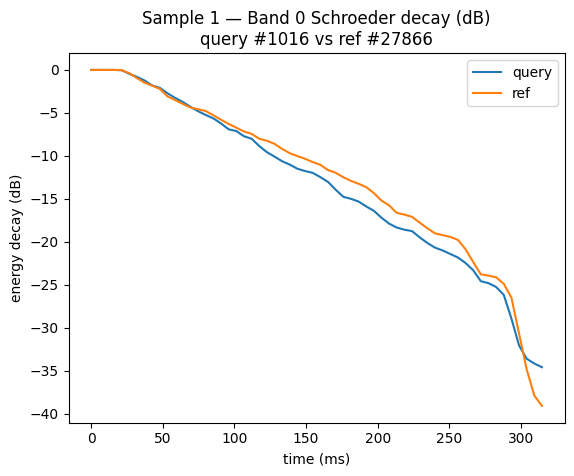

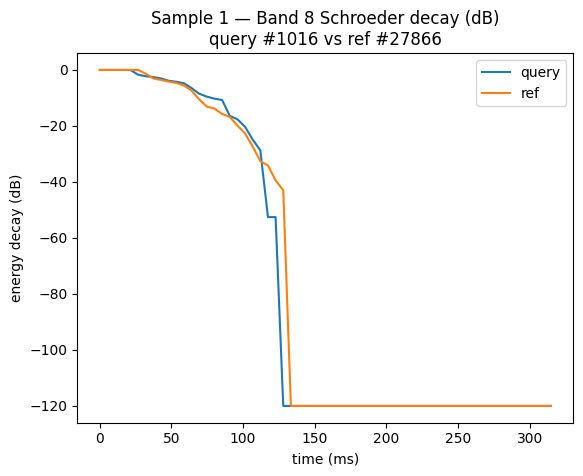

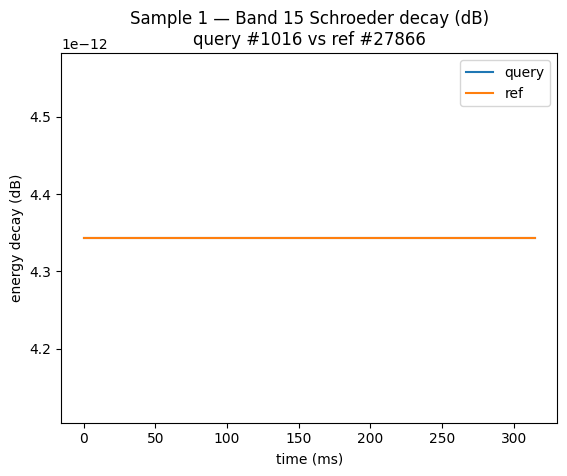


=== Sample 2: query #1902 vs ref #16543 ===
   late_slope(dB/ms):  query(mean,z)=-0.481 | ref(mean,z)=-0.428 | Δ=-0.052
       knee_time(ms):  query(mean,z)=+0.238 | ref(mean,z)=+0.226 | Δ=+0.012
             EDT(ms):  query(mean,z)=+0.217 | ref(mean,z)=+0.232 | Δ=-0.014
        early_energy:  query(mean,z)=-0.235 | ref(mean,z)=-0.235 | Δ=+0.001


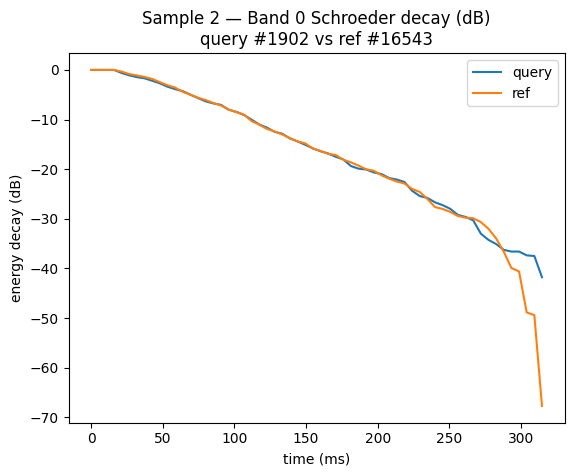

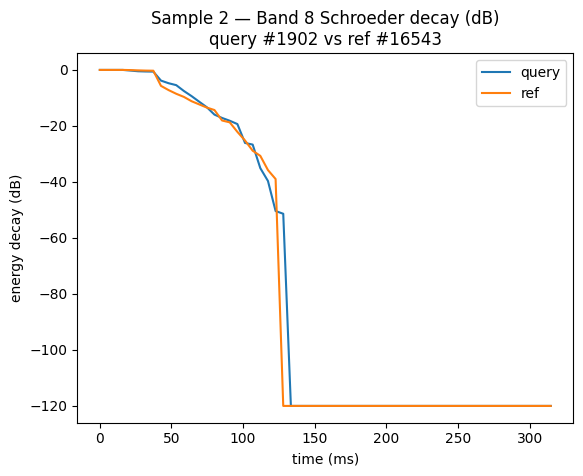

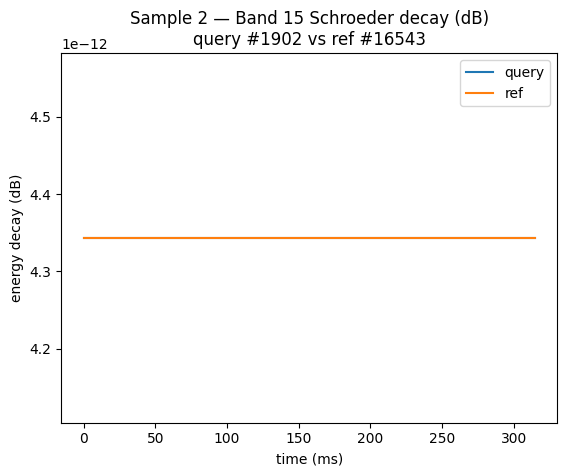


=== Sample 3: query #508 vs ref #24020 ===
   late_slope(dB/ms):  query(mean,z)=+0.201 | ref(mean,z)=+0.288 | Δ=-0.087
       knee_time(ms):  query(mean,z)=-0.105 | ref(mean,z)=-0.305 | Δ=+0.200
             EDT(ms):  query(mean,z)=-0.087 | ref(mean,z)=-0.063 | Δ=-0.024
        early_energy:  query(mean,z)=-0.151 | ref(mean,z)=-0.143 | Δ=-0.008


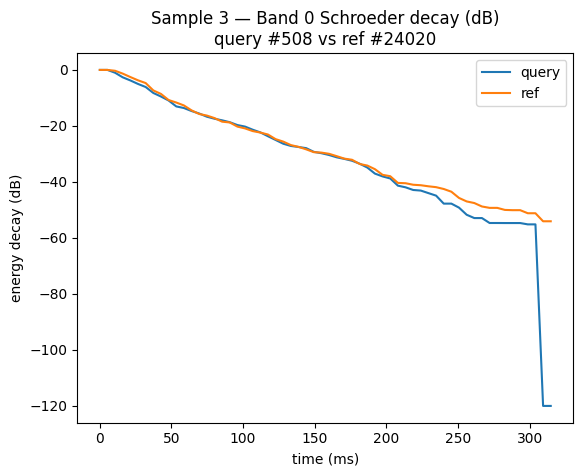

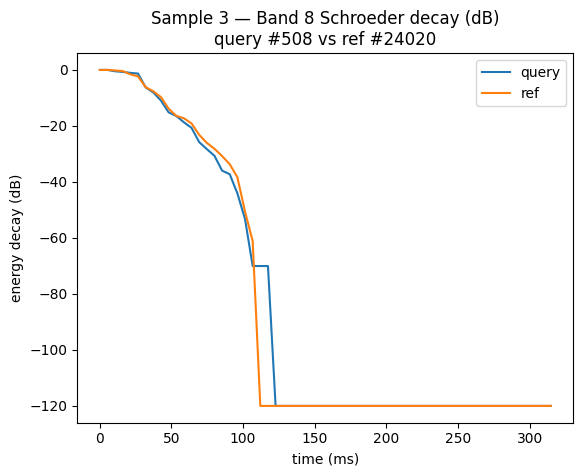

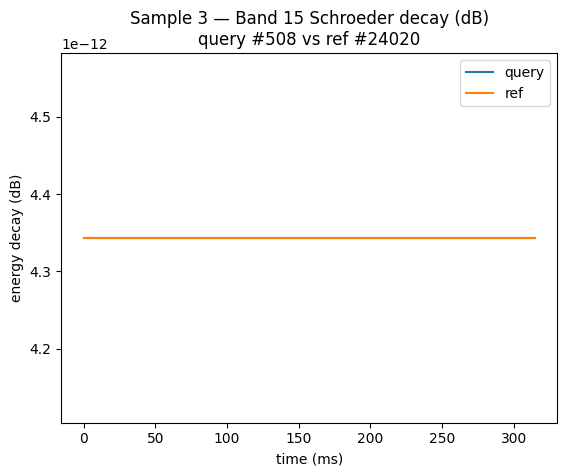


Done.


In [29]:
# === Sanity check: per-sample decay features vs reference (fixed for your RAFDataset) ===
import os, random, json, numpy as np
import matplotlib.pyplot as plt

from decay_features import (
    build_ref_decay_features_bank,
    compute_decay_features_for_ref,
)
from data import RAFDataset  # uses your actual ctor (no build_cache)  :contentReference[oaicite:0]{index=0}

# ------------------- ONLY KNOB -------------------
NUM_BANDS = 16
# -------------------------------------------------

SCENE_ROOT = "../NeRAF/data/RAF/FurnishedRoom"
FEATS_DIR  = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY  = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

# Build tiny datasets with RAG enabled so we get ref bank + top-K indices baked in :contentReference[oaicite:1]{index=1}
rag_cfg = {"enabled": True, "k": 8}  # any k>0 turns on ref bank building in RAFDataset

# Probe ds to read hop + fs (ds.hop is in samples; ds.sample_rate is Hz)  :contentReference[oaicite:2]{index=2}
ds_val = RAFDataset(scene_root=SCENE_ROOT, split="validation", model_kind="neraf",
                    sample_rate=48000, dataset_mode="full", reverbrag_cfg=rag_cfg)
HOP_MS = (ds_val.hop / ds_val.sample_rate) * 1000.0  # hop_len/sr → ms  :contentReference[oaicite:3]{index=3}

def load_ref_bank_logmag():
    # Prefer the ready-made bank from the dataset (float32 log-mag)  :contentReference[oaicite:4]{index=4}
    ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train", model_kind="neraf",
                        sample_rate=48000, dataset_mode="full", reverbrag_cfg=rag_cfg)
    bank = getattr(ds_ref, "ref_bank_stft", None)  # [R,1,F,60] or empty  :contentReference[oaicite:5]{index=5}
    if bank is not None and bank.numel() > 0:
        return bank.cpu().numpy().astype(np.float32), ds_ref
    # Fallback: build bank by enumerating ids (slow path)
    R = len(ds_ref.ids)
    F = ds_ref.F_bins; T = ds_ref.max_frames  # 60  :contentReference[oaicite:6]{index=6}
    bank_np = np.zeros((R, 1, F, T), dtype=np.float32)
    for i, sid in enumerate(ds_ref.ids):
        st = ds_ref._mm_fetch_stft(sid).squeeze(0).numpy().astype(np.float32)  # [F,60]  :contentReference[oaicite:7]{index=7}
        bank_np[i, 0] = st
    return bank_np, ds_ref

def get_ref_feats():
    if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
        feats = np.load(REF_FEATS_NPY)  # [R,B,4], float32
        with open(REF_FEATS_JSON, "r") as f:
            stats = json.load(f)
        return feats, stats
    ref_bank_np, _ = load_ref_bank_logmag()
    feats, stats = build_ref_decay_features_bank(ref_bank_np, num_bands=NUM_BANDS, hop_ms=HOP_MS)
    np.save(REF_FEATS_NPY, feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(stats, f, indent=2)
    return feats, stats

# Random queries from validation; rely on dataset attaching top-K ref indices if available  :contentReference[oaicite:8]{index=8}
def sample_queries(n=3):
    items = []
    for qi in random.sample(range(len(ds_val)), k=min(n, len(ds_val))):
        it = ds_val[qi]
        stft = it["stft"].squeeze(0).numpy().astype(np.float64)  # [F,60] log-mag  :contentReference[oaicite:9]{index=9}
        ref_idx = None
        if "ref_indices" in it:
            arr = np.array(it["ref_indices"])
            if arr.size > 0:
                ref_idx = int(arr.reshape(-1)[0])
        items.append({"q_idx": qi, "q_stft": stft, "ref_idx": ref_idx})
    return items

# Schroeder curve helper for plotting
def schroeder_from_logmag_band(logmag_band):
    mag = np.exp(logmag_band) - 1e-3
    mag[mag < 0.0] = 0.0
    E = mag * mag
    S = E[::-1].cumsum()[::-1]
    if S[0] <= 1e-12:
        S = S + 1e-12
    S = S / S[0]
    return 10.0 * np.log10(S + 1e-12)

# ---------- RUN ----------
ref_feats, ref_stats = get_ref_feats()            # [R,B,4], μ/σ from bank
ref_bank_np, ds_ref = load_ref_bank_logmag()      # [R,1,F,60] float32 log-mag
R = ref_bank_np.shape[0]
means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)

def compute_query_feats_norm(q_logmag_FT):
    raw = compute_decay_features_for_ref(q_logmag_FT, num_bands=NUM_BANDS, hop_ms=HOP_MS)  # [B,4] float64
    norm = (raw - means[None, :]) / (stds[None, :] + 1e-12)
    return raw, norm.astype(np.float32)

def pool_linear_bands(S_log_FT, B):
    F, T = S_log_FT.shape
    edges = np.linspace(0, F, B+1, dtype=int)
    S_band = np.zeros((B, T), dtype=np.float64)
    for b in range(B):
        sl = np.exp(S_log_FT[edges[b]:edges[b+1], :]) - 1e-3
        sl[sl < 0] = 0
        S_band[b] = np.log(sl.mean(axis=0) + 1e-12)
    return S_band

queries = sample_queries(n=3)
for it in queries:
    if it["ref_idx"] is None or it["ref_idx"] >= R or it["ref_idx"] < 0:
        it["ref_idx"] = random.randint(0, R-1)

feat_names = ["late_slope(dB/ms)", "knee_time(ms)", "EDT(ms)", "early_energy"]

for i, it in enumerate(queries, 1):
    q_idx, ref_idx = it["q_idx"], it["ref_idx"]
    q_raw, q_norm = compute_query_feats_norm(it["q_stft"])  # [B,4]
    r_norm = ref_feats[ref_idx]                              # [B,4]
    delta = q_norm - r_norm

    print(f"\n=== Sample {i}: query #{q_idx} vs ref #{ref_idx} ===")
    for f, name in enumerate(feat_names):
        q_mean = float(q_norm[:, f].mean())
        r_mean = float(r_norm[:, f].mean())
        d_mean = float(delta[:, f].mean())
        print(f"  {name:>18}:  query(mean,z)={q_mean:+.3f} | ref(mean,z)={r_mean:+.3f} | Δ={d_mean:+.3f}")

    # Plot Schroeder curves for a few bands
    bands_to_plot = [0, NUM_BANDS//2, NUM_BANDS-1] if NUM_BANDS >= 3 else [0]
    q_band = pool_linear_bands(it["q_stft"], NUM_BANDS)
    r_band = pool_linear_bands(ref_bank_np[ref_idx,0].astype(np.float64), NUM_BANDS)

    T = q_band.shape[1]
    t = np.arange(T) * HOP_MS
    for b in bands_to_plot:
        q_db = schroeder_from_logmag_band(q_band[b])
        r_db = schroeder_from_logmag_band(r_band[b])
        plt.figure()
        plt.title(f"Sample {i} — Band {b} Schroeder decay (dB)\nquery #{q_idx} vs ref #{ref_idx}")
        plt.plot(t, q_db, label="query")
        plt.plot(t, r_db, label="ref")
        plt.xlabel("time (ms)")
        plt.ylabel("energy decay (dB)")
        plt.legend()
        plt.show()

print("\nDone.")

Evaluating: 100%|██████████| 100/100 [00:00<00:00, 334.19sample/s]



=== Retrieval Decay-Feature Alignment (100 samples) ===
     late_slope:  mean |Δz| = 0.121 ± 0.075
      knee_time:  mean |Δz| = 0.132 ± 0.055
            EDT:  mean |Δz| = 0.050 ± 0.045
   early_energy:  mean |Δz| = 0.124 ± 0.496

Global mean |Δz| = 0.107


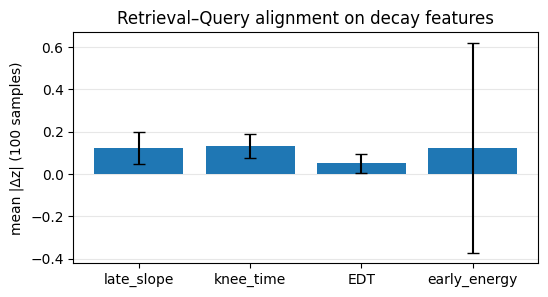

In [30]:
# === Batch retrieval audit over 100 random samples ===
import random, numpy as np, json
from tqdm import tqdm
from decay_features import compute_decay_features_for_ref
from data import RAFDataset

NUM_BANDS = 16
SCENE_ROOT = "../NeRAF/data/RAF/FurnishedRoom"
FEATS_DIR  = f"{SCENE_ROOT}/feats"
REF_FEATS_NPY  = f"{FEATS_DIR}/ref_decay_feats_B{NUM_BANDS}.npy"
REF_FEATS_JSON = f"{FEATS_DIR}/ref_decay_stats_B{NUM_BANDS}.json"

# --- load reference features + stats ---
ref_feats = np.load(REF_FEATS_NPY)                     # [R,B,4] float32 normalized
with open(REF_FEATS_JSON, "r") as f:
    ref_stats = json.load(f)
means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)
HOP_MS = float(ref_stats["hop_ms"])

# --- build datasets (validation and train/reference) ---
rag_cfg = {"enabled": True, "k": 8}
ds_val = RAFDataset(scene_root=SCENE_ROOT, split="validation",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)
ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)
R = len(ds_ref)

# --- helper to normalize query features like ref bank ---
def compute_query_feats_norm(q_logmag_FT):
    raw = compute_decay_features_for_ref(q_logmag_FT, num_bands=NUM_BANDS, hop_ms=HOP_MS)
    norm = (raw - means[None, :]) / (stds[None, :] + 1e-12)
    return norm.astype(np.float32)

# --- run for 100 random samples ---
N = min(100, len(ds_val))
feat_names = ["late_slope", "knee_time", "EDT", "early_energy"]
deltas = np.zeros((N, 4), dtype=np.float64)

for i, qi in enumerate(tqdm(random.sample(range(len(ds_val)), N), desc="Evaluating", unit="sample")):
    q_item = ds_val[qi]
    q_stft = q_item["stft"].squeeze(0).numpy().astype(np.float64)
    q_feats = compute_query_feats_norm(q_stft)  # [B,4]

    ref_idx = None
    if "ref_indices" in q_item:
        arr = np.array(q_item["ref_indices"])
        if arr.size > 0:
            ref_idx = int(arr.reshape(-1)[0])
    if ref_idx is None or ref_idx < 0 or ref_idx >= R:
        ref_idx = random.randint(0, R - 1)

    r_feats = ref_feats[ref_idx]  # [B,4]
    delta = np.abs(q_feats - r_feats).mean(axis=0)  # [4], mean over bands
    deltas[i] = delta

# --- summarize ---
mean_d = deltas.mean(axis=0)
std_d  = deltas.std(axis=0)

print("\n=== Retrieval Decay-Feature Alignment (100 samples) ===")
for f, name in enumerate(feat_names):
    print(f"{name:>15}:  mean |Δz| = {mean_d[f]:.3f} ± {std_d[f]:.3f}")
print(f"\nGlobal mean |Δz| = {mean_d.mean():.3f}")

# Optional: quick bar plot
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3))
plt.bar(feat_names, mean_d, yerr=std_d, capsize=4)
plt.ylabel("mean |Δz| (100 samples)")
plt.title("Retrieval–Query alignment on decay features")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [ ]:
#!/usr/bin/env python3
# IMPORTANT: This is the FIXED version of build_references.py
# build_references_fixed.py
# Retrieval with: EDC-from-STFT (T=60), rank-fusion, and top-K re-rank by decay features.

import os, json, math, glob, random
import numpy as np
import numba
from tqdm import tqdm
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# ==============================
#             KNOBS
# ==============================
SCENE_ROOT      = "../NeRAF/data/RAF/EmptyRoom"
SPLIT_JSON_PATH = os.path.join(SCENE_ROOT, "metadata", "data-split.json")
OUT_JSON_PATH   = "./references_empty_fixed.json"

REF_SPLIT   = "reference"        # which split to use as the ref bank
NUM_BANDS   = 32                 # the ONLY public knob
W_STFT, W_EDC = 0.4, 0.6         # weights for rank-fusion (relative influence)
K_FUSE      = 50                 # take top-K after fusion before re-ranking by features
K_SAVE      = 10                 # save top-10 per query

# Performance
Q_CHUNK     = 256                # process queries in chunks
DRY_RUN_K   = None               # e.g. 100 to sanity-check; None = all queries

# ==============================
#        Low-level helpers
# ==============================

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

def _row_ranks(D):
    # ranks in [0..R-1], lower is better
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks.astype(np.float64)

@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60) log-mag
    # EDC on the same 60-frame grid as the model
    F, T = S_log_FT.shape
    mag = np.empty_like(S_log_FT)
    for i in range(F):
        for j in range(T):
            v = math.exp(S_log_FT[i, j]) - 1e-3
            mag[i, j] = v if v > 0.0 else 0.0
    E = (mag * mag).sum(axis=0)                # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    out = np.empty_like(edc)
    for t in range(edc.size):
        out[t] = 10.0 * math.log10(edc[t] + 1e-12)
    return out

def _iter_chunks(n, chunk):
    if chunk is None or chunk >= n:
        yield 0, n
    else:
        for s in range(0, n, chunk):
            e = min(s + chunk, n)
            yield s, e

# ==============================
#         Load splits
# ==============================
with open(SPLIT_JSON_PATH, "r") as f:
    splits = json.load(f)

# Queries = all splits except REF_SPLIT
query_ids, query_splits = [], []
for k, v in splits.items():
    if k.lower() == REF_SPLIT.lower():
        continue
    ids_k = v[0] if (isinstance(v, list) and len(v) > 0 and isinstance(v[0], list)) else v
    for sid in ids_k:
        query_ids.append(sid); query_splits.append(k)

# Reference ids
ref_src = splits[REF_SPLIT]
ref_ids = ref_src[0] if (isinstance(ref_src, list) and len(ref_src) > 0 and isinstance(ref_src[0], list)) else ref_src
ref_ids = list(ref_ids)

if isinstance(DRY_RUN_K, int) and DRY_RUN_K > 0:
    query_ids   = query_ids[:DRY_RUN_K]
    query_splits= query_splits[:DRY_RUN_K]

print(f"[info] #Queries={len(query_ids)} (dry-run={DRY_RUN_K if DRY_RUN_K else 'OFF'}), #Refs={len(ref_ids)}")

# ==============================
#         Datasets
# ==============================
def _make_ds(split):
    # reverbrag_cfg only ensures ref bank + indices are available if needed; not required here
    return RAFDataset(scene_root=SCENE_ROOT, split=split, model_kind="neraf",
                      sample_rate=48000, dataset_mode="full")

ds_ref = _make_ds(REF_SPLIT)
id2idx_ref = ds_ref.id2idx

ds_cache = {}
def _get_ds_for_split(sname):
    if sname not in ds_cache:
        ds_cache[sname] = _make_ds(sname)
    return ds_cache[sname]

# Basic dims
F_bins = ds_ref.F_bins
T      = ds_ref.max_frames
assert T == 60, f"Expected T=60 frames, got {T}"
hop_ms = (ds_ref.hop / ds_ref.sample_rate) * 1000.0

# ==============================
#      Reference matrices
# ==============================
print("[info] Loading reference set (STFT+EDC-from-STFT)…")
R = len(ref_ids)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC  = np.empty((R, T),          dtype=np.float64)
for ii, sid in enumerate(tqdm(ref_ids, desc="Load refs")):
    it   = ds_ref[id2idx_ref[sid]]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)   # (F,60) log-mag
    REF_STFT[ii] = Slog.reshape(-1)
    REF_EDC[ii]  = _edc_db_from_stft_logmag(Slog)             # (60,)

# ==============================
#  Decay-feature cache for re-rank
# ==============================
FEATS_DIR       = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY   = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON  = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
    ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32 (normalized)
    with open(REF_FEATS_JSON, "r") as f:
        ref_stats = json.load(f)
else:
    # Build bank from ref STFTs (assemble into [R,1,F,60])
    bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
    for i, sid in enumerate(ref_ids):
        st = ds_ref[id2idx_ref[sid]]["stft"].squeeze(0).numpy().astype(np.float32)
        bank_np[i,0] = st
    feats_np, ref_stats = build_ref_decay_features_bank(bank_np, num_bands=NUM_BANDS, hop_ms=hop_ms)
    ref_feats = feats_np  # [R,B,4] float32 (normalized)
    np.save(REF_FEATS_NPY, ref_feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(ref_stats, f, indent=2)

means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)

def _query_feats_norm(Slog_FT):
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=NUM_BANDS, hop_ms=hop_ms)  # [B,4] float64
    return ((raw - means[None,:]) / (stds[None,:] + 1e-12)).astype(np.float32)

# ==============================
#        Build queries
# ==============================
print("[info] Loading queries (STFT+EDC-from-STFT)…")
Q = len(query_ids)
Q_STFT = np.empty((Q, F_bins*T), dtype=np.float64)
Q_EDC  = np.empty((Q, T),          dtype=np.float64)
q_id_index = []
for qi, (sid, sname) in enumerate(tqdm(list(zip(query_ids, query_splits)), total=Q, desc="Load queries")):
    ds   = _get_ds_for_split(sname)
    it   = ds[ds.id2idx[sid]]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)   # (F,60)
    Q_STFT[qi] = Slog.reshape(-1)
    Q_EDC[qi]  = _edc_db_from_stft_logmag(Slog)
    q_id_index.append(sid)

# ==============================
#     Retrieval + Re-rank
# ==============================
print("[info] Compute & rank (rank-fusion + top-K feature re-rank)…")
result = {}
num_chunks = sum(1 for _ in _iter_chunks(Q, Q_CHUNK))
pbar = tqdm(total=num_chunks, desc="Rank chunks")

for i0, i1 in _iter_chunks(Q, Q_CHUNK):
    # Distances on the 60-frame grid
    D_stft = _pairwise_l2(Q_STFT[i0:i1], REF_STFT)    # (q,R)
    D_edc  = _pairwise_l1(Q_EDC[i0:i1],  REF_EDC)     # (q,R)

    # Rank fusion (lower = better)
    r_stft = _row_ranks(D_stft)
    r_edc  = _row_ranks(D_edc)
    rank_mix = W_STFT * r_stft + W_EDC * r_edc        # (q,R)

    # For each row, take top-K and re-rank by feature L1 in z-space
    for local_idx, qi in enumerate(range(i0, i1)):
        qid = q_id_index[qi]
        # candidates by rank fusion
        cand_idx = np.argpartition(rank_mix[local_idx], K_FUSE)[:K_FUSE]  # unsorted K
        # remove self if present
        cand_ids = [ref_ids[j] for j in cand_idx if ref_ids[j] != qid]
        if len(cand_ids) == 0:
            cand_ids = [ref_ids[j] for j in cand_idx]  # fallback keep if all filtered
        # re-rank by banded 4-feature z-space distance (mean L1 over B×4)
        # compute query features (once)
        Slog_q = Q_STFT[qi].reshape(F_bins, T)
        q_feat = _query_feats_norm(Slog_q)            # [B,4] float32
        # gather candidate features
        cand_idx2 = [id2idx_ref[c] for c in cand_ids]
        cand_feats = ref_feats[cand_idx2]             # [K,B,4] float32
        # clip z to [-3,3] to tame outliers
        cf = np.clip(cand_feats, -3.0, 3.0)
        qf = np.clip(q_feat,      -3.0, 3.0)
        d_feat = np.abs(cf - qf[None,:,:]).mean(axis=(1,2))  # [K]
        order = np.argsort(d_feat)
        top_ids = [cand_ids[i] for i in order[:K_SAVE]]
        result[qid] = top_ids

    pbar.update(1)

pbar.close()

# ==============================
#           Save
# ==============================
with open(OUT_JSON_PATH, "w") as f:
    json.dump(result, f, indent=2)
print(f"[saved] Top-{K_SAVE} retrieval JSON -> {OUT_JSON_PATH}")
print("Example item:", next(iter(result.items())))

[info] #Queries=47484 (dry-run=OFF), #Refs=37987
[info] Loading reference set (STFT+EDC-from-STFT)…


Load refs: 100%|██████████| 37987/37987 [01:21<00:00, 464.85it/s]


[info] Loading queries (STFT+EDC-from-STFT)…


Load queries: 100%|██████████| 47484/47484 [01:57<00:00, 402.97it/s]


[info] Compute & rank (rank-fusion + top-K feature re-rank)…


Rank chunks: 100%|██████████| 186/186 [3:15:36<00:00, 63.10s/it]  


[saved] Top-10 retrieval JSON -> ./references_empty_fixed.json
Example item: ('026251', ['026261', '008589', '005587', '037542', '008588', '005580', '026244', '026256', '026257', '026264'])


In [4]:
#!/usr/bin/env python3
# IMPORTANT: This is the FIXED version of build_references.py
# build_references_fixed.py
# Retrieval with: EDC-from-STFT (T=60), rank-fusion, and top-K re-rank by decay features.

import os, json, math, glob, random
import numpy as np
import numba
from tqdm import tqdm
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# ==============================
#             KNOBS
# ==============================
SCENE_ROOT      = "../NeRAF/data/RAF/FurnishedRoom"
SPLIT_JSON_PATH = os.path.join(SCENE_ROOT, "metadata", "data-split.json")
OUT_JSON_PATH   = "./references_furnished_fixed.json"

REF_SPLIT   = "reference"        # which split to use as the ref bank
NUM_BANDS   = 32                 # the ONLY public knob
W_STFT, W_EDC = 0.4, 0.6         # weights for rank-fusion (relative influence)
K_FUSE      = 50                 # take top-K after fusion before re-ranking by features
K_SAVE      = 10                 # save top-10 per query

# Performance
Q_CHUNK     = 256                # process queries in chunks
DRY_RUN_K   = None               # e.g. 100 to sanity-check; None = all queries

# ==============================
#        Low-level helpers
# ==============================

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

def _row_ranks(D):
    # ranks in [0..R-1], lower is better
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks.astype(np.float64)

@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60) log-mag
    # EDC on the same 60-frame grid as the model
    F, T = S_log_FT.shape
    mag = np.empty_like(S_log_FT)
    for i in range(F):
        for j in range(T):
            v = math.exp(S_log_FT[i, j]) - 1e-3
            mag[i, j] = v if v > 0.0 else 0.0
    E = (mag * mag).sum(axis=0)                # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    out = np.empty_like(edc)
    for t in range(edc.size):
        out[t] = 10.0 * math.log10(edc[t] + 1e-12)
    return out

def _iter_chunks(n, chunk):
    if chunk is None or chunk >= n:
        yield 0, n
    else:
        for s in range(0, n, chunk):
            e = min(s + chunk, n)
            yield s, e

# ==============================
#         Load splits
# ==============================
with open(SPLIT_JSON_PATH, "r") as f:
    splits = json.load(f)

# Queries = all splits except REF_SPLIT
query_ids, query_splits = [], []
for k, v in splits.items():
    if k.lower() == REF_SPLIT.lower():
        continue
    ids_k = v[0] if (isinstance(v, list) and len(v) > 0 and isinstance(v[0], list)) else v
    for sid in ids_k:
        query_ids.append(sid); query_splits.append(k)

# Reference ids
ref_src = splits[REF_SPLIT]
ref_ids = ref_src[0] if (isinstance(ref_src, list) and len(ref_src) > 0 and isinstance(ref_src[0], list)) else ref_src
ref_ids = list(ref_ids)

if isinstance(DRY_RUN_K, int) and DRY_RUN_K > 0:
    query_ids   = query_ids[:DRY_RUN_K]
    query_splits= query_splits[:DRY_RUN_K]

print(f"[info] #Queries={len(query_ids)} (dry-run={DRY_RUN_K if DRY_RUN_K else 'OFF'}), #Refs={len(ref_ids)}")

# ==============================
#         Datasets
# ==============================
def _make_ds(split):
    # reverbrag_cfg only ensures ref bank + indices are available if needed; not required here
    return RAFDataset(scene_root=SCENE_ROOT, split=split, model_kind="neraf",
                      sample_rate=48000, dataset_mode="full")

ds_ref = _make_ds(REF_SPLIT)
id2idx_ref = ds_ref.id2idx

ds_cache = {}
def _get_ds_for_split(sname):
    if sname not in ds_cache:
        ds_cache[sname] = _make_ds(sname)
    return ds_cache[sname]

# Basic dims
F_bins = ds_ref.F_bins
T      = ds_ref.max_frames
assert T == 60, f"Expected T=60 frames, got {T}"
hop_ms = (ds_ref.hop / ds_ref.sample_rate) * 1000.0

# ==============================
#      Reference matrices
# ==============================
print("[info] Loading reference set (STFT+EDC-from-STFT)…")
R = len(ref_ids)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC  = np.empty((R, T),          dtype=np.float64)
for ii, sid in enumerate(tqdm(ref_ids, desc="Load refs")):
    it   = ds_ref[id2idx_ref[sid]]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)   # (F,60) log-mag
    REF_STFT[ii] = Slog.reshape(-1)
    REF_EDC[ii]  = _edc_db_from_stft_logmag(Slog)             # (60,)

# ==============================
#  Decay-feature cache for re-rank
# ==============================
FEATS_DIR       = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY   = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON  = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
    ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32 (normalized)
    with open(REF_FEATS_JSON, "r") as f:
        ref_stats = json.load(f)
else:
    # Build bank from ref STFTs (assemble into [R,1,F,60])
    bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
    for i, sid in enumerate(ref_ids):
        st = ds_ref[id2idx_ref[sid]]["stft"].squeeze(0).numpy().astype(np.float32)
        bank_np[i,0] = st
    feats_np, ref_stats = build_ref_decay_features_bank(bank_np, num_bands=NUM_BANDS, hop_ms=hop_ms)
    ref_feats = feats_np  # [R,B,4] float32 (normalized)
    np.save(REF_FEATS_NPY, ref_feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(ref_stats, f, indent=2)

means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)

def _query_feats_norm(Slog_FT):
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=NUM_BANDS, hop_ms=hop_ms)  # [B,4] float64
    return ((raw - means[None,:]) / (stds[None,:] + 1e-12)).astype(np.float32)

# ==============================
#        Build queries
# ==============================
print("[info] Loading queries (STFT+EDC-from-STFT)…")
Q = len(query_ids)
Q_STFT = np.empty((Q, F_bins*T), dtype=np.float64)
Q_EDC  = np.empty((Q, T),          dtype=np.float64)
q_id_index = []
for qi, (sid, sname) in enumerate(tqdm(list(zip(query_ids, query_splits)), total=Q, desc="Load queries")):
    ds   = _get_ds_for_split(sname)
    it   = ds[ds.id2idx[sid]]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)   # (F,60)
    Q_STFT[qi] = Slog.reshape(-1)
    Q_EDC[qi]  = _edc_db_from_stft_logmag(Slog)
    q_id_index.append(sid)

# ==============================
#     Retrieval + Re-rank
# ==============================
print("[info] Compute & rank (rank-fusion + top-K feature re-rank)…")
result = {}
num_chunks = sum(1 for _ in _iter_chunks(Q, Q_CHUNK))
pbar = tqdm(total=num_chunks, desc="Rank chunks")

for i0, i1 in _iter_chunks(Q, Q_CHUNK):
    # Distances on the 60-frame grid
    D_stft = _pairwise_l2(Q_STFT[i0:i1], REF_STFT)    # (q,R)
    D_edc  = _pairwise_l1(Q_EDC[i0:i1],  REF_EDC)     # (q,R)

    # Rank fusion (lower = better)
    r_stft = _row_ranks(D_stft)
    r_edc  = _row_ranks(D_edc)
    rank_mix = W_STFT * r_stft + W_EDC * r_edc        # (q,R)

    # For each row, take top-K and re-rank by feature L1 in z-space
    for local_idx, qi in enumerate(range(i0, i1)):
        qid = q_id_index[qi]
        # candidates by rank fusion
        cand_idx = np.argpartition(rank_mix[local_idx], K_FUSE)[:K_FUSE]  # unsorted K
        # remove self if present
        cand_ids = [ref_ids[j] for j in cand_idx if ref_ids[j] != qid]
        if len(cand_ids) == 0:
            cand_ids = [ref_ids[j] for j in cand_idx]  # fallback keep if all filtered
        # re-rank by banded 4-feature z-space distance (mean L1 over B×4)
        # compute query features (once)
        Slog_q = Q_STFT[qi].reshape(F_bins, T)
        q_feat = _query_feats_norm(Slog_q)            # [B,4] float32
        # gather candidate features
        cand_idx2 = [id2idx_ref[c] for c in cand_ids]
        cand_feats = ref_feats[cand_idx2]             # [K,B,4] float32
        # clip z to [-3,3] to tame outliers
        cf = np.clip(cand_feats, -3.0, 3.0)
        qf = np.clip(q_feat,      -3.0, 3.0)
        d_feat = np.abs(cf - qf[None,:,:]).mean(axis=(1,2))  # [K]
        order = np.argsort(d_feat)
        top_ids = [cand_ids[i] for i in order[:K_SAVE]]
        result[qid] = top_ids

    pbar.update(1)

pbar.close()

# ==============================
#           Save
# ==============================
with open(OUT_JSON_PATH, "w") as f:
    json.dump(result, f, indent=2)
print(f"[saved] Top-{K_SAVE} retrieval JSON -> {OUT_JSON_PATH}")
print("Example item:", next(iter(result.items())))

[info] #Queries=39132 (dry-run=OFF), #Refs=31305
[info] Loading reference set (STFT+EDC-from-STFT)…


Building decay features (CPU): 100%|██████████| 31305/31305 [00:53<00:00, 588.79ref/s]


[info] Loading queries (STFT+EDC-from-STFT)…


Load queries: 100%|██████████| 39132/39132 [07:11<00:00, 90.67it/s] 


[info] Compute & rank (rank-fusion + top-K feature re-rank)…


Rank chunks: 100%|██████████| 153/153 [33:03<00:00, 12.97s/it]


[saved] Top-10 retrieval JSON -> ./references_furnished_fixed.json
Example item: ('026564', ['026552', '006822', '005609', '026538', '019050', '006445', '026559', '036962', '019076', '006832'])


In [13]:
# === A/B: fixed retrieval with vs. without re-rank (100 queries) ===
# Fixed retrieval = STFT(L2) + EDC-from-STFT(60) + rank-fusion
# B adds top-K re-rank by the 4 normalized decay features over bands.

import os, json, math, random, numpy as np
from tqdm import tqdm
import numba
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# --------------------- KNOBS (minimal) ---------------------
NUM_SAMPLES = 100      # queries
NUM_BANDS   = 32       # used only for the re-rank features
K_FUSE      = 50       # candidates taken from rank-fusion before re-rank
W_STFT, W_EDC = 0.4, 0.6
SCENE_ROOT  = "../NeRAF/data/RAF/FurnishedRoom"
# -----------------------------------------------------------

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

def _row_ranks(D):
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks.astype(np.float64)

@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60)
    F, T = S_log_FT.shape
    mag = np.empty_like(S_log_FT)
    for i in range(F):
        for j in range(T):
            v = math.exp(S_log_FT[i, j]) - 1e-3
            mag[i, j] = v if v > 0.0 else 0.0
    E = (mag * mag).sum(axis=0)             # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    out = np.empty_like(edc)
    for t in range(edc.size):
        out[t] = 10.0 * math.log10(edc[t] + 1e-12)
    return out

# ---- Datasets ----
rag_cfg = {"enabled": True, "k": max(K_FUSE, 8)}
ds_val = RAFDataset(scene_root=SCENE_ROOT, split="validation",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)
ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)

F_bins = ds_val.F_bins
T      = ds_val.max_frames
assert T == 60, f"Expected T=60, got {T}"

# ---- Reference matrices for fusion (fixed retrieval) ----
R = len(ds_ref)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC  = np.empty((R, T),          dtype=np.float64)
for i in tqdm(range(R), desc="Load refs"):
    it = ds_ref[i]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)
    REF_STFT[i] = Slog.reshape(-1)
    REF_EDC[i]  = _edc_db_from_stft_logmag(Slog)

# ---- Ref decay-feature cache for re-rank ----
FEATS_DIR       = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY   = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON  = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
    ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32
    with open(REF_FEATS_JSON, "r") as f:
        ref_stats = json.load(f)
else:
    bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
    for i in range(R):
        bank_np[i,0] = ds_ref[i]["stft"].squeeze(0).numpy().astype(np.float32)
    hop_ms = (ds_ref.hop / ds_ref.sample_rate) * 1000.0
    feats_np, ref_stats = build_ref_decay_features_bank(bank_np, num_bands=NUM_BANDS, hop_ms=hop_ms)
    ref_feats = feats_np
    np.save(REF_FEATS_NPY, ref_feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(ref_stats, f, indent=2)

means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)

def _q_feats_norm_from_Slog(Slog_FT):
    hop_ms = (ds_val.hop / ds_val.sample_rate) * 1000.0
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=NUM_BANDS, hop_ms=hop_ms)  # [B,4] float64
    return ((raw - means[None,:]) / (stds[None,:] + 1e-12)).astype(np.float32)

# ---- Pick same random queries ----
rng = random.Random(123)
q_indices = rng.sample(range(len(ds_val)), k=min(NUM_SAMPLES, len(ds_val)))

feat_names = ["late_slope", "knee_time", "EDT", "early_energy"]
A_abs_dz = np.zeros((len(q_indices), 4), dtype=np.float64)  # no re-rank
B_abs_dz = np.zeros((len(q_indices), 4), dtype=np.float64)  # with re-rank
changed = 0
improved = 0

for n, qi in enumerate(tqdm(q_indices, desc="Eval queries", unit="q")):
    it = ds_val[qi]
    Slog_q = it["stft"].squeeze(0).numpy().astype(np.float64)  # (F,60)
    q_stft = Slog_q.reshape(-1)[None,:]                         # (1,F*T)
    q_edc  = _edc_db_from_stft_logmag(Slog_q)[None,:]           # (1,60)

    # --- fixed rank-fusion (no re-rank) ---
    D_stft = _pairwise_l2(q_stft, REF_STFT)
    D_edc  = _pairwise_l1(q_edc,  REF_EDC)
    r_stft = _row_ranks(D_stft)
    r_edc  = _row_ranks(D_edc)
    mix    = (W_STFT * r_stft + W_EDC * r_edc)[0]               # (R,)
    top1_A = int(np.argmin(mix))

    # --- fixed rank-fusion + top-K re-rank by 4-feature z-space ---
    topk_idx = np.argpartition(mix, K_FUSE)[:K_FUSE]
    q_feat = _q_feats_norm_from_Slog(Slog_q.reshape(F_bins, T)) # [B,4]
    cf = np.clip(ref_feats[topk_idx], -3.0, 3.0)                # [K,B,4]
    qf = np.clip(q_feat,            -3.0, 3.0)                  # [B,4]
    d_feat = np.abs(cf - qf[None,:,:]).mean(axis=(1,2))         # [K]
    top1_B = int(topk_idx[np.argmin(d_feat)])

    if top1_B != top1_A:
        changed += 1

    # --- evaluate alignment for both picks ---
    qN = q_feat
    rA = ref_feats[top1_A]
    rB = ref_feats[top1_B]
    A_abs_dz[n] = np.abs(qN - rA).mean(axis=0)
    B_abs_dz[n] = np.abs(qN - rB).mean(axis=0)
    if A_abs_dz[n].mean() > B_abs_dz[n].mean():
        improved += 1

# ---- Report ----
meanA, stdA = A_abs_dz.mean(axis=0), A_abs_dz.std(axis=0)
meanB, stdB = B_abs_dz.mean(axis=0), B_abs_dz.std(axis=0)
improv = meanA - meanB

print("\n=== Fixed retrieval A/B (No re-rank vs Re-rank) on {} queries ===".format(len(q_indices)))
for f, name in enumerate(feat_names):
    print(f"{name:>15}:  no-rerank={meanA[f]:.3f}±{stdA[f]:.3f}   rerank={meanB[f]:.3f}±{stdB[f]:.3f}   Δ={improv[f]:+.3f}")
print(f"\nGlobal mean |Δz|:  no-rerank={meanA.mean():.3f}  rerank={meanB.mean():.3f}  Δ={meanA.mean()-meanB.mean():+.3f}")
print(f"Changed top-1 in {changed}/{len(q_indices)} queries ({100.0*changed/len(q_indices):.1f}%).")
print(f"Improved top-1 in {improved}/{len(q_indices)} queries ({100.0*improved/len(q_indices):.1f}%).")


Load refs: 100%|██████████| 31305/31305 [01:15<00:00, 414.08it/s]
Eval queries: 100%|██████████| 100/100 [01:26<00:00,  1.16q/s]
=== Fixed retrieval A/B (No re-rank vs Re-rank) on 100 queries ===
     late_slope:  no-rerank=0.556±0.345   rerank=0.133±0.085   Δ=+0.424
      knee_time:  no-rerank=0.502±0.270   rerank=0.166±0.073   Δ=+0.336
            EDT:  no-rerank=0.218±0.159   rerank=0.083±0.051   Δ=+0.135
   early_energy:  no-rerank=0.226±0.330   rerank=0.075±0.147   Δ=+0.151

Global mean |Δz|:  no-rerank=0.376  rerank=0.114  Δ=+0.262
Changed top-1 in 98/100 queries (98.0%).
Improved top-1 in 98/100 queries (98.0%).

Eval queries: 100%|██████████| 100/100 [01:15<00:00,  1.33q/s]


=== Fixed retrieval A/B (No re-rank vs Re-rank) on 100 queries ===
     late_slope:  no-rerank=0.144±0.095   rerank=0.098±0.064   Δ=+0.047
      knee_time:  no-rerank=0.166±0.053   rerank=0.134±0.034   Δ=+0.033
            EDT:  no-rerank=0.050±0.023   rerank=0.046±0.018   Δ=+0.004
   early_energy:  no-rerank=0.051±0.089   rerank=0.038±0.054   Δ=+0.013

Global mean |Δz|:  no-rerank=0.103  rerank=0.079  Δ=+0.024
Changed top-1 in 82/100 queries (82.0%).
Improved top-1 in 82/100 queries (82.0%).


In [ ]:
# === A/B test: "current" vs "fixed 60-frame timebase + rank-fusion + feature re-rank" on 100 queries ===
import os, json, random, math, numpy as np
from tqdm import tqdm
import numba
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# ------------- KNOBS -------------
NUM_SAMPLES = 100
NUM_BANDS   = 32
K_TOP       = 10           # top-K to re-rank by 4-feature vector
W_STFT, W_EDC = 0.4, 0.6   # only used by the "current" pipeline; rank fusion ignores absolute weights
SCENE_ROOT  = "../NeRAF/data/RAF/FurnishedRoom"
# ---------------------------------

FEATS_DIR  = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY  = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

# ---------------- Helpers ----------------
@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True)
def _zscore_rowwise(M):
    Q, R = M.shape
    Z = np.empty_like(M)
    for i in range(Q):
        mu = 0.0
        for j in range(R): mu += M[i,j]
        mu /= R
        sd = 0.0
        for j in range(R):
            d = M[i,j]-mu; sd += d*d
        sd = math.sqrt(sd/(R+1e-12)) + 1e-12
        for j in range(R):
            Z[i,j] = (M[i,j]-mu) / sd
    return Z

def _row_ranks(D):
    # ranks in [0..R-1], lower is better
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks

# EDC from waveform (old) with naive downsampling by index (your current behaviour)
@numba.njit(fastmath=True)
def _edc_db_waveform_naive(wav, bins=60):
    e = wav * wav
    edc = np.cumsum(e[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    edc_db = 10.0 * np.log10(edc + 1e-12)
    idx = np.linspace(0, edc_db.size - 1, bins).astype(np.int64)
    return edc_db[idx]

@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60)
    mag = np.exp(S_log_FT) - 1e-3
    for i in range(mag.shape[0]):
        for j in range(mag.shape[1]):
            if mag[i,j] < 0.0:
                mag[i,j] = 0.0
    E = (mag*mag).sum(axis=0)             # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    return 10.0 * np.log10(edc + 1e-12)   # (60,)

# ------------- Load datasets -------------
rag_cfg = {"enabled": True, "k": max(K_TOP, 8)}
ds_val = RAFDataset(scene_root=SCENE_ROOT, split="validation",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)
ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)

# Basic dims
F_bins = ds_val.F_bins
T = ds_val.max_frames  # should be 60
assert T == 60, f"Expected T=60, got {T}"

# Assemble reference matrices (flattened STFT, EDC_old, EDC_new)
R = len(ds_ref)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC_OLD = np.empty((R, T), dtype=np.float64)
REF_EDC_NEW = np.empty((R, T), dtype=np.float64)

for i in tqdm(range(R), desc="Load refs"):
    it = ds_ref[i]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)  # (F,60) log-mag
    wav  = it["wav"].squeeze(0).numpy().astype(np.float64)   # (Tw,)
    REF_STFT[i]   = Slog.reshape(-1)
    REF_EDC_OLD[i] = _edc_db_waveform_naive(wav, bins=T)
    REF_EDC_NEW[i] = _edc_db_from_stft_logmag(Slog)

# Load or build ref decay features and stats (for top-K re-rank & query z-normalization)
if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
    ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32
    with open(REF_FEATS_JSON, "r") as f:
        ref_stats = json.load(f)
else:
    # build from ref bank STFT
    # Prefer ds_ref.ref_bank_stft if it exists; else reconstruct
    if getattr(ds_ref, "ref_bank_stft", None) is not None and ds_ref.ref_bank_stft.numel() > 0:
        bank_np = ds_ref.ref_bank_stft.cpu().numpy().astype(np.float32)
    else:
        bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
        for i in range(R):
            Slog = ds_ref[i]["stft"].squeeze(0).numpy().astype(np.float32)
            bank_np[i,0] = Slog
    feats_np, ref_stats = build_ref_decay_features_bank(bank_np, num_bands=NUM_BANDS,
                                                        hop_ms=(ds_val.hop/ds_val.sample_rate)*1000.0)
    ref_feats = feats_np  # [R,B,4] float32
    np.save(REF_FEATS_NPY, ref_feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(ref_stats, f, indent=2)

means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)

def query_feats_norm_from_Slog(Slog_FT):
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=NUM_BANDS,
                                         hop_ms=(ds_val.hop/ds_val.sample_rate)*1000.0)  # [B,4] float64
    norm = (raw - means[None,:]) / (stds[None,:] + 1e-12)
    return norm.astype(np.float32)

# ------------- Pick 20 queries -------------
rng = random.Random(123)
q_indices = rng.sample(range(len(ds_val)), k=min(NUM_SAMPLES, len(ds_val)))

# Storage for |Δz| (mean over bands) per feature
feat_names = ["late_slope", "knee_time", "EDT", "early_energy"]
A_abs_dz = np.zeros((len(q_indices), 4), dtype=np.float64)
B_abs_dz = np.zeros((len(q_indices), 4), dtype=np.float64)

for n, qi in enumerate(tqdm(q_indices, desc="A/B on queries", unit="q")):
    it = ds_val[qi]
    Slog_q = it["stft"].squeeze(0).numpy().astype(np.float64)  # (F,60)
    wav_q  = it["wav"].squeeze(0).numpy().astype(np.float64)   # (Tw,)

    # Query vectors for retrieval
    q_stft = Slog_q.reshape(-1)[None, :]            # (1, F*T)
    q_edc_old = _edc_db_waveform_naive(wav_q, T)[None, :]  # (1, 60)
    q_edc_new = _edc_db_from_stft_logmag(Slog_q)[None, :]  # (1, 60)

    # ---------- A: current pipeline ----------
    D_stft_A = _pairwise_l2(q_stft, REF_STFT)           # (1,R)
    D_edc_A  = _pairwise_l1(q_edc_old, REF_EDC_OLD)     # (1,R)
    Z_stft   = _zscore_rowwise(D_stft_A)
    Z_edc    = _zscore_rowwise(D_edc_A)
    mix_A    = W_STFT * Z_stft + W_EDC * Z_edc          # (1,R)
    top1_A   = int(np.argmin(mix_A[0]))

    # ---------- B: fixed pipeline ----------
    # rank-fusion on distances (lower better)
    D_stft_B = _pairwise_l2(q_stft, REF_STFT)
    D_edc_B  = _pairwise_l1(q_edc_new, REF_EDC_NEW)
    r_stft   = _row_ranks(D_stft_B)
    r_edc    = _row_ranks(D_edc_B)
    rank_mix = (W_STFT * r_stft + W_EDC * r_edc)[0]     # (R,)

    # take top-K by rank, then re-rank by 4-feature banded z-space
    topk_idx = np.argpartition(rank_mix, K_TOP)[:K_TOP]
    q_feats_norm = query_feats_norm_from_Slog(Slog_q.reshape(F_bins, T))
    # compute mean L1 over bands&features to each candidate
    cand = ref_feats[topk_idx]  # [K,B,4]
    # broadcast [B,4]
    d_feat = np.abs(cand - q_feats_norm[None, :, :]).mean(axis=(1,2))  # [K]
    top1_B = int(topk_idx[np.argmin(d_feat)])

    # ---------- Evaluate both picks ----------
    # get ref features
    rA = ref_feats[top1_A]  # [B,4]
    rB = ref_feats[top1_B]  # [B,4]
    qN = q_feats_norm       # [B,4]

    A_abs_dz[n] = np.abs(qN - rA).mean(axis=0)  # [4]
    B_abs_dz[n] = np.abs(qN - rB).mean(axis=0)

# ------------- Report -------------
meanA, stdA = A_abs_dz.mean(axis=0), A_abs_dz.std(axis=0)
meanB, stdB = B_abs_dz.mean(axis=0), B_abs_dz.std(axis=0)
improv = meanA - meanB

print("\n=== A/B Retrieval Alignment on 20 queries (mean |Δz| over bands) ===")
for f, name in enumerate(feat_names):
    print(f"{name:>15}:  A={meanA[f]:.3f}±{stdA[f]:.3f}   B={meanB[f]:.3f}±{stdB[f]:.3f}   Δ(A−B)={improv[f]:+.3f}")
print(f"\nGlobal mean |Δz|:  A={meanA.mean():.3f}  B={meanB.mean():.3f}  Δ(A−B)={meanA.mean()-meanB.mean():+.3f}")


Load refs: 100%|██████████| 31305/31305 [01:26<00:00, 361.02it/s]
A/B on queries: 100%|██████████| 100/100 [02:51<00:00,  1.71s/q]
=== A/B Retrieval Alignment on 20 queries (mean |Δz| over bands) ===
     late_slope:  A=0.575±0.338   B=0.218±0.165   Δ(A−B)=+0.357
      knee_time:  A=0.517±0.302   B=0.218±0.092   Δ(A−B)=+0.299
            EDT:  A=0.217±0.158   B=0.121±0.102   Δ(A−B)=+0.096
   early_energy:  A=0.268±0.428   B=0.099±0.160   Δ(A−B)=+0.169

Global mean |Δz|:  A=0.394  B=0.164  Δ(A−B)=+0.230

A/B on queries: 100%|██████████| 100/100 [02:35<00:00,  1.55s/q]


=== A/B Retrieval Alignment on 20 queries (mean |Δz| over bands) ===
     late_slope:  A=0.137±0.085   B=0.108±0.070   Δ(A−B)=+0.029
      knee_time:  A=0.163±0.046   B=0.142±0.038   Δ(A−B)=+0.020
            EDT:  A=0.050±0.024   B=0.049±0.022   Δ(A−B)=+0.001
   early_energy:  A=0.045±0.073   B=0.039±0.057   Δ(A−B)=+0.006

Global mean |Δz|:  A=0.099  B=0.085  Δ(A−B)=+0.014


In [19]:
# === Band sensitivity test: NUM_BANDS = 16 vs 32 (same candidates, different re-rank) ===
import os, json, math, random, numpy as np
from tqdm import tqdm
import numba
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# --------------------- KNOBS ---------------------
NUM_SAMPLES = 100
BANDS_A = 16
BANDS_B = 32
K_FUSE   = 50        # top-K from rank-fusion to re-rank by banded features
W_STFT, W_EDC = 0.4, 0.6
SCENE_ROOT = "../NeRAF/data/RAF/FurnishedRoom"
# ------------------------------------------------

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

def _row_ranks(D):
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks.astype(np.float64)

@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60)
    F, T = S_log_FT.shape
    mag = np.empty_like(S_log_FT)
    for i in range(F):
        for j in range(T):
            v = math.exp(S_log_FT[i, j]) - 1e-3
            mag[i, j] = v if v > 0.0 else 0.0
    E = (mag * mag).sum(axis=0)             # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    out = np.empty_like(edc)
    for t in range(edc.size):
        out[t] = 10.0 * math.log10(edc[t] + 1e-12)
    return out

# ---- Datasets ----
rag_cfg = {"enabled": True, "k": max(K_FUSE, 8)}
ds_val = RAFDataset(scene_root=SCENE_ROOT, split="validation",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)
ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)

F_bins = ds_val.F_bins
T      = ds_val.max_frames
assert T == 60, f"Expected T=60, got {T}"

# ---- Reference matrices for candidate fusion (independent of bands) ----
R = len(ds_ref)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC  = np.empty((R, T),          dtype=np.float64)
for i in tqdm(range(R), desc="Load refs"):
    it = ds_ref[i]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)
    REF_STFT[i] = Slog.reshape(-1)
    REF_EDC[i]  = _edc_db_from_stft_logmag(Slog)

# ---- Helpers to load/build banded caches for A and B ----
def _load_or_build_ref_feats(BANDS):
    FEATS_DIR      = os.path.join(SCENE_ROOT, "feats")
    os.makedirs(FEATS_DIR, exist_ok=True)
    REF_FEATS_NPY  = os.path.join(FEATS_DIR, f"ref_decay_feats_B{BANDS}.npy")
    REF_FEATS_JSON = os.path.join(FEATS_DIR, f"ref_decay_stats_B{BANDS}.json")
    if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
        feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32
        with open(REF_FEATS_JSON, "r") as f:
            stats = json.load(f)
        return feats, stats
    # build from ref STFT
    bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
    for i in range(R):
        bank_np[i,0] = ds_ref[i]["stft"].squeeze(0).numpy().astype(np.float32)
    hop_ms = (ds_ref.hop / ds_ref.sample_rate) * 1000.0
    feats_np, stats = build_ref_decay_features_bank(bank_np, num_bands=BANDS, hop_ms=hop_ms)
    np.save(REF_FEATS_NPY, feats_np)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(stats, f, indent=2)
    return feats_np, stats

ref_feats_A, stats_A = _load_or_build_ref_feats(BANDS_A)   # [R,BA,4]
ref_feats_B, stats_B = _load_or_build_ref_feats(BANDS_B)   # [R,BB,4]
means_A = np.array(stats_A["means"], dtype=np.float64); stds_A = np.array(stats_A["stds"], dtype=np.float64)
means_B = np.array(stats_B["means"], dtype=np.float64); stds_B = np.array(stats_B["stds"], dtype=np.float64)

def _q_feats_norm(Slog_FT, means, stds, BANDS):
    hop_ms = (ds_val.hop / ds_val.sample_rate) * 1000.0
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=BANDS, hop_ms=hop_ms)  # [B,4] float64
    return ((raw - means[None,:]) / (stds[None,:] + 1e-12)).astype(np.float32)

# ---- Pick same random queries ----
rng = random.Random(123)
q_indices = rng.sample(range(len(ds_val)), k=min(NUM_SAMPLES, len(ds_val)))

feat_names = ["late_slope", "knee_time", "EDT", "early_energy"]
A_abs_dz = np.zeros((len(q_indices), 4), dtype=np.float64)  # bands=16
B_abs_dz = np.zeros((len(q_indices), 4), dtype=np.float64)  # bands=32
changed = improved = 0

for n, qi in enumerate(tqdm(q_indices, desc="Eval queries", unit="q")):
    it = ds_val[qi]
    Slog_q = it["stft"].squeeze(0).numpy().astype(np.float64)  # (F,60)
    q_stft = Slog_q.reshape(-1)[None,:]
    q_edc  = _edc_db_from_stft_logmag(Slog_q)[None,:]

    # --- fixed rank-fusion candidates (same for both band settings) ---
    D_stft = _pairwise_l2(q_stft, REF_STFT)
    D_edc  = _pairwise_l1(q_edc,  REF_EDC)
    r_stft = _row_ranks(D_stft)
    r_edc  = _row_ranks(D_edc)
    mix    = (W_STFT * r_stft + W_EDC * r_edc)[0]           # (R,)
    topk_idx = np.argpartition(mix, K_FUSE)[:K_FUSE]

    # --- re-rank with BANDS_A ---
    qA = _q_feats_norm(Slog_q.reshape(F_bins, T), means_A, stds_A, BANDS_A)   # [BA,4]
    candA = np.clip(ref_feats_A[topk_idx], -3.0, 3.0)                         # [K,BA,4]
    dA = np.abs(candA - np.clip(qA, -3.0, 3.0)[None,:,:]).mean(axis=(1,2))    # [K]
    top1_A = int(topk_idx[np.argmin(dA)])

    # --- re-rank with BANDS_B ---
    qB = _q_feats_norm(Slog_q.reshape(F_bins, T), means_B, stds_B, BANDS_B)   # [BB,4]
    candB = np.clip(ref_feats_B[topk_idx], -3.0, 3.0)                         # [K,BB,4]
    dB = np.abs(candB - np.clip(qB, -3.0, 3.0)[None,:,:]).mean(axis=(1,2))    # [K]
    top1_B = int(topk_idx[np.argmin(dB)])

    if top1_B != top1_A:
        changed += 1

    # --- evaluate alignment using each band setting's own z-space ---
    A_abs_dz[n] = np.abs(qA - ref_feats_A[top1_A]).mean(axis=0)
    B_abs_dz[n] = np.abs(qB - ref_feats_B[top1_B]).mean(axis=0)
    if A_abs_dz[n].mean() > B_abs_dz[n].mean():
        improved += 1

# ---- Report ----
meanA, stdA = A_abs_dz.mean(axis=0), A_abs_dz.std(axis=0)
meanB, stdB = B_abs_dz.mean(axis=0), B_abs_dz.std(axis=0)
improv = meanA - meanB

print(f"\n=== Band test on {len(q_indices)} queries: B={BANDS_A} vs B={BANDS_B} (same candidates) ===")
for f, name in enumerate(feat_names):
    print(f"{name:>15}:  B={BANDS_A}: {meanA[f]:.3f}±{stdA[f]:.3f}   B={BANDS_B}: {meanB[f]:.3f}±{stdB[f]:.3f}   Δ={improv[f]:+.3f}")
print(f"\nGlobal mean |Δz|:  B={BANDS_A}: {meanA.mean():.3f}   B={BANDS_B}: {meanB.mean():.3f}   Δ={meanA.mean()-meanB.mean():+.3f}")
print(f"Changed top-1 in {changed}/{len(q_indices)} queries ({100.0*changed/len(q_indices):.1f}%).")
print(f"B={BANDS_B} improved in {improved}/{len(q_indices)} queries ({100.0*improved/len(q_indices):.1f}%).")

Eval queries: 100%|██████████| 100/100 [01:47<00:00,  1.07s/q]


=== Band test on 100 queries: B=16 vs B=32 (same candidates) ===
     late_slope:  B=16: 0.133±0.085   B=32: 0.098±0.064   Δ=+0.035
      knee_time:  B=16: 0.166±0.073   B=32: 0.134±0.034   Δ=+0.033
            EDT:  B=16: 0.083±0.051   B=32: 0.046±0.018   Δ=+0.037
   early_energy:  B=16: 0.075±0.147   B=32: 0.038±0.054   Δ=+0.037

Global mean |Δz|:  B=16: 0.114   B=32: 0.079   Δ=+0.035
Changed top-1 in 98/100 queries (98.0%).
B=32 improved in 84/100 queries (84.0%).


In [21]:
# === Retrieval vs GT audit: Baseline (old) vs Best (fixed+re-rank), evaluated at B=16 and B=32 ===
import os, json, math, random, numpy as np
from tqdm import tqdm
import numba
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# ---------------- KNOBS ----------------
NUM_SAMPLES = 100
BANDS_LIST  = [32, 64]   # evaluate both
K_FUSE      = 50         # candidates for re-rank
W_STFT, W_EDC = 0.4, 0.6
SCENE_ROOT  = "../NeRAF/data/RAF/FurnishedRoom"
# ---------------------------------------

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

@numba.njit(fastmath=True)
def _zscore_rowwise(M):
    Q, R = M.shape
    Z = np.empty_like(M)
    for i in range(Q):
        mu = 0.0
        for j in range(R):
            mu += M[i, j]
        mu /= R
        sd = 0.0
        for j in range(R):
            d = M[i, j] - mu
            sd += d * d
        sd = math.sqrt(sd / (R + 1e-12)) + 1e-12
        for j in range(R):
            Z[i, j] = (M[i, j] - mu) / sd
    return Z

def _row_ranks(D):
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks.astype(np.float64)

# Old (baseline) EDC from waveform with naive downsampling (your previous method)
@numba.njit(fastmath=True)
def _edc_db_waveform_naive(wav, bins=60):
    e = wav * wav
    edc = np.cumsum(e[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    edc_db = 10.0 * np.log10(edc + 1e-12)
    idx = np.linspace(0, edc_db.size - 1, bins).astype(np.int64)
    return edc_db[idx]

# New (fixed) EDC on the model's 60-frame grid from STFT log-mag
@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60)
    F, T = S_log_FT.shape
    mag = np.empty_like(S_log_FT)
    for i in range(F):
        for j in range(T):
            v = math.exp(S_log_FT[i, j]) - 1e-3
            mag[i, j] = v if v > 0.0 else 0.0
    E = (mag * mag).sum(axis=0)             # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    out = np.empty_like(edc)
    for t in range(edc.size):
        out[t] = 10.0 * math.log10(edc[t] + 1e-12)
    return out

# ---- Datasets ----
rag_cfg = {"enabled": True, "k": max(K_FUSE, 8)}
ds_val = RAFDataset(scene_root=SCENE_ROOT, split="validation",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)
ds_ref = RAFDataset(scene_root=SCENE_ROOT, split="train",
                    model_kind="neraf", sample_rate=48000,
                    dataset_mode="full", reverbrag_cfg=rag_cfg)

F_bins = ds_val.F_bins
T      = ds_val.max_frames
assert T == 60, f"Expected T=60, got {T}"

# ---- Reference matrices (shared) ----
R = len(ds_ref)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC_OLD = np.empty((R, T), dtype=np.float64)
REF_EDC_NEW = np.empty((R, T), dtype=np.float64)
for i in tqdm(range(R), desc="Load refs"):
    it = ds_ref[i]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)
    wav  = it["wav"].squeeze(0).numpy().astype(np.float64)
    REF_STFT[i]   = Slog.reshape(-1)
    REF_EDC_OLD[i] = _edc_db_waveform_naive(wav, bins=T)
    REF_EDC_NEW[i] = _edc_db_from_stft_logmag(Slog)

# ---- Build/load banded caches for each B in BANDS_LIST ----
band_envs = {}
for BANDS in BANDS_LIST:
    FEATS_DIR      = os.path.join(SCENE_ROOT, "feats")
    os.makedirs(FEATS_DIR, exist_ok=True)
    REF_FEATS_NPY  = os.path.join(FEATS_DIR, f"ref_decay_feats_B{BANDS}.npy")
    REF_FEATS_JSON = os.path.join(FEATS_DIR, f"ref_decay_stats_B{BANDS}.json")
    if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
        ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32
        with open(REF_FEATS_JSON, "r") as f:
            stats = json.load(f)
    else:
        bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
        for j in range(R):
            bank_np[j,0] = ds_ref[j]["stft"].squeeze(0).numpy().astype(np.float32)
        hop_ms = (ds_ref.hop / ds_ref.sample_rate) * 1000.0
        feats_np, stats = build_ref_decay_features_bank(bank_np, num_bands=BANDS, hop_ms=hop_ms)
        ref_feats = feats_np
        np.save(REF_FEATS_NPY, ref_feats)
        with open(REF_FEATS_JSON, "w") as f:
            json.dump(stats, f, indent=2)
    means = np.array(stats["means"], dtype=np.float64)
    stds  = np.array(stats["stds"],  dtype=np.float64)
    band_envs[BANDS] = dict(ref_feats=ref_feats, means=means, stds=stds)

def _q_feats_norm(Slog_FT, means, stds, BANDS):
    hop_ms = (ds_val.hop / ds_val.sample_rate) * 1000.0
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=BANDS, hop_ms=hop_ms)
    return ((raw - means[None,:]) / (stds[None,:] + 1e-12)).astype(np.float32)

# ---- Sample queries ----
rng = random.Random(123)
q_indices = rng.sample(range(len(ds_val)), k=min(NUM_SAMPLES, len(ds_val)))

feat_names = ["late_slope", "knee_time", "EDT", "early_energy"]

# Storage: for each B, keep per-query |Δz| for Baseline vs Best
scores = {B: {"baseline": np.zeros((len(q_indices), 4), dtype=np.float64),
              "best":     np.zeros((len(q_indices), 4), dtype=np.float64)}
          for B in BANDS_LIST}

for n, qi in enumerate(tqdm(q_indices, desc="Evaluate queries", unit="q")):
    it = ds_val[qi]
    Slog_q = it["stft"].squeeze(0).numpy().astype(np.float64)
    wav_q  = it["wav"].squeeze(0).numpy().astype(np.float64)

    # Baseline retrieval (old): STFT L2 + waveform EDC (naive) + rowwise z-score fusion
    q_stft = Slog_q.reshape(-1)[None,:]
    q_edc_old = _edc_db_waveform_naive(wav_q, T)[None,:]
    D_stft_A = _pairwise_l2(q_stft, REF_STFT)
    D_edc_A  = _pairwise_l1(q_edc_old, REF_EDC_OLD)
    Z_stft   = _zscore_rowwise(D_stft_A)
    Z_edc    = _zscore_rowwise(D_edc_A)
    mix_A    = W_STFT * Z_stft + W_EDC * Z_edc
    top1_A   = int(np.argmin(mix_A[0]))

    # Best retrieval (fixed): STFT L2 + EDC-from-STFT + rank-fusion, then per-B re-rank
    q_edc_new = _edc_db_from_stft_logmag(Slog_q)[None,:]
    D_stft_B  = _pairwise_l2(q_stft, REF_STFT)
    D_edc_B   = _pairwise_l1(q_edc_new, REF_EDC_NEW)
    r_stft    = _row_ranks(D_stft_B)
    r_edc     = _row_ranks(D_edc_B)
    rank_mix  = (W_STFT * r_stft + W_EDC * r_edc)[0]
    topk_idx  = np.argpartition(rank_mix, K_FUSE)[:K_FUSE]

    # For each band setting, compute query z, re-rank, and evaluate |Δz|
    for BANDS in BANDS_LIST:
        env = band_envs[BANDS]
        ref_feats = env["ref_feats"]         # [R,B,4]
        means, stds = env["means"], env["stds"]

        qN = _q_feats_norm(Slog_q.reshape(F_bins, T), means, stds, BANDS)  # [B,4]

        # Baseline pick evaluated in this band-space
        r_baseline = ref_feats[top1_A]  # [B,4]
        scores[BANDS]["baseline"][n] = np.abs(qN - r_baseline).mean(axis=0)

        # Best pick: re-rank the same candidates in this band-space
        cand_feats = np.clip(ref_feats[topk_idx], -3.0, 3.0)   # [K,B,4]
        d_feat = np.abs(cand_feats - np.clip(qN, -3.0, 3.0)[None,:,:]).mean(axis=(1,2))  # [K]
        top1_B = int(topk_idx[np.argmin(d_feat)])

        r_best = ref_feats[top1_B]
        scores[BANDS]["best"][n] = np.abs(qN - r_best).mean(axis=0)

# ---- Report ----
for BANDS in BANDS_LIST:
    print(f"\n=== Retrieval vs GT in band-space B={BANDS} on {len(q_indices)} queries ===")
    for tag in ["baseline", "best"]:
        mean = scores[BANDS][tag].mean(axis=0)
        std  = scores[BANDS][tag].std(axis=0)
        gmean = mean.mean()
        print(f"[{tag:8}] per-feature mean |Δz|  (± std):")
        for f, name in enumerate(feat_names):
            print(f"  {name:>15}: {mean[f]:.3f} ± {std[f]:.3f}")
        print(f"  {'global':>15}: {gmean:.3f}")

    # Improvement
    imp = scores[BANDS]["baseline"].mean(axis=0) - scores[BANDS]["best"].mean(axis=0)
    print("  " + "-"*40)
    print("  Improvement (baseline − best), per feature:")
    for f, name in enumerate(feat_names):
        print(f"  {name:>15}: {imp[f]:+.3f}")
    print(f"  {'global':>15}: {scores[BANDS]['baseline'].mean():.3f} → {scores[BANDS]['best'].mean():.3f}  "
          f"Δ={scores[BANDS]['baseline'].mean()-scores[BANDS]['best'].mean():+.3f}")

Evaluate queries: 100%|██████████| 100/100 [03:54<00:00,  2.35s/q]


=== Retrieval vs GT in band-space B=32 on 100 queries ===
[baseline] per-feature mean |Δz|  (± std):
       late_slope: 0.137 ± 0.085
        knee_time: 0.163 ± 0.046
              EDT: 0.050 ± 0.024
     early_energy: 0.045 ± 0.073
           global: 0.099
[best    ] per-feature mean |Δz|  (± std):
       late_slope: 0.098 ± 0.064
        knee_time: 0.134 ± 0.034
              EDT: 0.046 ± 0.018
     early_energy: 0.038 ± 0.054
           global: 0.079
  ----------------------------------------
  Improvement (baseline − best), per feature:
       late_slope: +0.039
        knee_time: +0.029
              EDT: +0.003
     early_energy: +0.007
           global: 0.099 → 0.079  Δ=+0.020

=== Retrieval vs GT in band-space B=64 on 100 queries ===
[baseline] per-feature mean |Δz|  (± std):
       late_slope: 0.162 ± 0.086
        knee_time: 0.183 ± 0.033
              EDT: 0.061 ± 0.022
     early_energy: 0.052 ± 0.080
           global: 0.115
[best    ] per-feature mean |Δz|  (± std):
   

In [3]:
# === CELL 0: Setup & knobs ====================================================
import os, json, random, math, numpy as np, torch
from collections import defaultdict
from tqdm.auto import tqdm

# If evaluator.py / data.py are not on sys.path, add them here:
import sys
EXTRA_PATHS = [
    ".",                    # current
    "/mnt/data",            # where you said evaluator.py/data.py live
]
for p in EXTRA_PATHS:
    if p not in sys.path: sys.path.append(p)

from evaluator import UnifiedEvaluator   # returns keys: stft, edc, t60, edt, c50
from data import RAFDataset

# ------------------------ USER KNOBS (edit these) -----------------------------
SCENE_ROOT   = "../NeRAF/data/RAF/EmptyRoom"   # RAF scene root
JSON_A_PATH  = "./references_empty.json"                  # first GT-ref JSON (mapping: qid -> [ref1, ref2, ...])
JSON_B_PATH  = "./references_empty_fixed.json"                  # second GT-ref JSON
SPLITS_TRY   = ("reference", "train", "validation", "test")  # where to look for IDs
N_QUERIES    = 20
SEED         = 1337

# Metrics to report (the "4 main"):
MAIN_KEYS    = ["stft", "t60", "edt", "c50"]       # evaluator returns these; lower = better
INCLUDE_EDC  = False                               # set True if you also want 'edc'
# ------------------------------------------------------------------------------

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cpu")  # force CPU as requested

# === CELL 1: Small helpers (lazy split cache; robust id fetch) ================
_ds_cache = {}
def _get_ds(split):
    if split not in _ds_cache:
        _ds_cache[split] = RAFDataset(
            scene_root=SCENE_ROOT,
            split=split,
            model_kind="neraf",
            sample_rate=48000,
            dataset_mode="full",
            reverbrag_cfg=None
        )
    return _ds_cache[split]

def fetch_stft_by_id(sid: str):
    """Return (F,T) float32 log-magnitude STFT for any sid by scanning splits."""
    for sp in SPLITS_TRY:
        ds = _get_ds(sp)
        if sid in ds.id2idx:
            item = ds[ds.id2idx[sid]]
            st = item["stft"].squeeze(0).numpy().astype(np.float32)  # (F,T)
            return st
    raise KeyError(f"ID {sid} not found in splits {SPLITS_TRY}")

# Wrap evaluator call for a single (ref, gt) pair
@torch.no_grad()
def eval_pair_stft_vs_gt(stft_ref_2d: np.ndarray, stft_gt_2d: np.ndarray, evaluator: UnifiedEvaluator):
    # evaluator expects [B,C,F,T] log-magnitude; RAF is mono so C=1, B=1
    A = torch.from_numpy(stft_ref_2d).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    B = torch.from_numpy(stft_gt_2d ).float().unsqueeze(0).unsqueeze(0).to(DEVICE)
    out = evaluator.evaluate(A, B)   # dict with 'stft','edc','t60','edt','c50'
    return out

# === CELL 2: Load JSONs & pick common random queries ==========================
with open(JSON_A_PATH, "r") as f:
    refmap_A = json.load(f)
with open(JSON_B_PATH, "r") as f:
    refmap_B = json.load(f)

# Force string keys
refmap_A = {str(k): [str(x) for x in v] for k, v in refmap_A.items()}
refmap_B = {str(k): [str(x) for x in v] for k, v in refmap_B.items()}

common_qids = sorted(set(refmap_A.keys()).intersection(refmap_B.keys()))
if len(common_qids) == 0:
    raise RuntimeError("No overlapping query IDs between the two JSON files.")
if len(common_qids) < N_QUERIES:
    print(f"[warn] Only {len(common_qids)} common queries available; reducing N_QUERIES.")
    N_QUERIES = len(common_qids)

rng = np.random.RandomState(SEED)
sampled_qids = list(rng.choice(common_qids, size=N_QUERIES, replace=False))
print(f"Using {len(sampled_qids)} common queries.")

# === CELL 3: Run evaluation (Top-1/2/3) for each file =========================
# Evaluator: EDC bins/metric only matters if INCLUDE_EDC=True; temporal metrics always computed.
evaluator = UnifiedEvaluator(fs=48000, edc_bins=60, edc_dist="l2")

def compare_one_file(refmap, tag):
    """
    For given mapping (qid -> [ref1, ref2, ...]), compute metrics for Top-1..3 vs GT.
    Returns:
        stats: dict with per-rank accumulators and per-query rows
    """
    rows = []           # per (qid, rank) metrics
    skipped = []        # track missing refs
    for qid in tqdm(sampled_qids, desc=f"{tag}: eval"):
        try:
            stft_gt = fetch_stft_by_id(qid)
        except KeyError:
            skipped.append(("gt_missing", qid))
            continue

        cand_list = refmap.get(qid, [])
        for rnk in (1, 2, 3):
            if len(cand_list) < rnk:
                skipped.append(("no_rank", qid, rnk))
                continue
            ref_id = cand_list[rnk-1]
            try:
                stft_ref = fetch_stft_by_id(ref_id)
            except KeyError:
                skipped.append(("ref_missing", qid, rnk, ref_id))
                continue

            out = eval_pair_stft_vs_gt(stft_ref, stft_gt, evaluator)
            if not INCLUDE_EDC:
                out = {k: v for k, v in out.items() if k in MAIN_KEYS}
            rows.append({
                "qid": qid, "rank": rnk, **out
            })

    # Aggregate
    keys = MAIN_KEYS + (["edc"] if INCLUDE_EDC else [])
    agg = {f"top{r}_{k}": [] for r in (1,2,3) for k in keys}
    for row in rows:
        r = row["rank"]
        for k in keys:
            v = row.get(k, float("nan"))
            if math.isfinite(v):
                agg[f"top{r}_{k}"].append(v)

    # Means & medians
    summary_mean = {k: (np.mean(v) if len(v)>0 else float("nan")) for k,v in agg.items()}
    summary_med  = {k: (np.median(v) if len(v)>0 else float("nan")) for k,v in agg.items()}

    return {
        "rows": rows,
        "skipped": skipped,
        "mean": summary_mean,
        "median": summary_med
    }

stats_A = compare_one_file(refmap_A, "JSON_A")
stats_B = compare_one_file(refmap_B, "JSON_B")

# === CELL 4: Pretty print summary & head-to-head ==============================
def _fmt(x): 
    if x is None or (isinstance(x, float) and not math.isfinite(x)): return "  NaN  "
    # scientific for insane values, fixed otherwise
    return f"{x:.6f}" if abs(x) < 1000 else f"{x:.2e}"

def print_summary(stats, label):
    keys = MAIN_KEYS + (["edc"] if INCLUDE_EDC else [])
    print(f"\n===== {label}: MEAN over {len(stats['rows'])} (qid,rank) rows =====")
    print("          " + "".join([f"{k:>12s}" for k in keys]))
    for r in (1,2,3):
        line = [f"Top-{r:<5d}"]
        for k in keys:
            line.append(_fmt(stats["mean"].get(f"top{r}_{k}", float("nan"))))
        print("".join([f"{x:>12s}" for x in line]))

print_summary(stats_A, "JSON_A")
print_summary(stats_B, "JSON_B")

# Head-to-head: which JSON wins (lower error) per metric & rank
keys = MAIN_KEYS + (["edc"] if INCLUDE_EDC else [])
print("\n===== HEAD-TO-HEAD (lower is better) =====")
print("          " + "".join([f"{k:>12s}" for k in keys]))
for r in (1,2,3):
    row = [f"Top-{r:<5d}"]
    for k in keys:
        a = stats_A["mean"].get(f"top{r}_{k}", float("nan"))
        b = stats_B["mean"].get(f"top{r}_{k}", float("nan"))
        if not (math.isfinite(a) and math.isfinite(b)):
            w = "NaN"
        elif a < b - 1e-9:
            w = "A⬇"
        elif b < a - 1e-9:
            w = "B⬇"
        else:
            w = "Tie"
        row.append(w)
    print("".join([f"{x:>12s}" for x in row]))

# Optional: show skip diagnostics
def summarize_skips(skips, label):
    from collections import Counter
    cnt = Counter([s[0] for s in skips])
    if cnt:
        print(f"\n[{label}] Skips: {dict(cnt)}")
        if len(skips) < 20:
            for s in skips: print("  ", s)

summarize_skips(stats_A["skipped"], "JSON_A")
summarize_skips(stats_B["skipped"], "JSON_B")

# === CELL 5 (optional): Pandas table for export ===============================
# If you want nice tables, uncomment this cell.
# import pandas as pd
# keys = MAIN_KEYS + (["edc"] if INCLUDE_EDC else [])
# def rows_to_df(rows):
#     return pd.DataFrame(rows)[["qid","rank"] + keys].sort_values(["rank","qid"])
# df_A = rows_to_df(stats_A["rows"])
# df_B = rows_to_df(stats_B["rows"])
# display(df_A.head(10)); display(df_B.head(10))

Using 20 common queries.


JSON_A: eval:   0%|          | 0/20 [00:00<?, ?it/s]

JSON_B: eval:   0%|          | 0/20 [00:00<?, ?it/s]


===== JSON_A: MEAN over 60 (qid,rank) rows =====
                  stft         t60         edt         c50
   Top-1        0.191266    4.320623    0.009306    0.335494
   Top-2        0.198204    6.559431    0.009413    0.432244
   Top-3        0.199641    6.716688    0.013412    0.471044

===== JSON_B: MEAN over 60 (qid,rank) rows =====
                  stft         t60         edt         c50
   Top-1        0.203452    8.840541    0.019581    0.742382
   Top-2        0.206455    9.235271    0.012450    0.493611
   Top-3        0.205633    8.827130    0.014506    0.667043

===== HEAD-TO-HEAD (lower is better) =====
                  stft         t60         edt         c50
   Top-1              A⬇          A⬇          A⬇          A⬇
   Top-2              A⬇          A⬇          A⬇          A⬇
   Top-3              A⬇          A⬇          A⬇          A⬇


In [ ]:
#!/usr/bin/env python3
# build_references_guarded.py
# Retrieval with: EDC-from-STFT (T=60), rank-fusion, and top-K re-rank by decay features
# + STFT guardrail to prevent spectrally odd references.

import os, json, math
import numpy as np
import numba
from tqdm import tqdm
from data import RAFDataset
from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref

# ==============================
#             KNOBS
# ==============================
SCENE_ROOT      = "../NeRAF/data/RAF/EmptyRoom"
SPLIT_JSON_PATH = os.path.join(SCENE_ROOT, "metadata", "data-split.json")
OUT_JSON_PATH   = "./references_empty_guarded.json"

REF_SPLIT   = "reference"        # which split to use as the ref bank
NUM_BANDS   = 32                 # banding for the 4 decay features
W_STFT, W_EDC = 0.4, 0.6         # weights for rank-fusion (relative influence)
K_FUSE      = 50                 # take top-K after fusion before re-ranking by features
K_SAVE      = 10                 # save top-10 per query

# --- STFT guardrail (soft blend + optional hard filter) ---
LAMBDA_STFT        = 0.10        # blend weight for z-scored STFT distance in re-rank (0.05–0.20 works well)
USE_HARD_FILTER    = False       # if True, drop far-spectral candidates before re-rank
STFT_FILTER_PCT    = 35.0        # keep candidates with STFT distance <= this percentile (per query)

# Performance
Q_CHUNK     = 256                # process queries in chunks
DRY_RUN_K   = None               # e.g. 100 to sanity-check; None = all queries

# ==============================
#        Low-level helpers
# ==============================

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l2(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                d = ai[k] - bj[k]
                s += d * d
            D[i, j] = math.sqrt(s)
    return D

@numba.njit(fastmath=True, parallel=True)
def _pairwise_l1(A, B):
    Q, R = A.shape[0], B.shape[0]
    D = np.empty((Q, R), np.float64)
    for i in numba.prange(Q):
        ai = A[i]
        for j in range(R):
            s = 0.0
            bj = B[j]
            for k in range(ai.size):
                s += abs(ai[k] - bj[k])
            D[i, j] = s
    return D

def _row_ranks(D):
    # ranks in [0..R-1], lower is better
    order = np.argsort(D, axis=1)
    ranks = np.empty_like(order)
    for i in range(D.shape[0]):
        ranks[i, order[i]] = np.arange(D.shape[1])
    return ranks.astype(np.float64)

@numba.njit(fastmath=True)
def _edc_db_from_stft_logmag(S_log_FT):  # (F,60) log-mag
    # EDC on the same 60-frame grid as the model
    F, T = S_log_FT.shape
    mag = np.empty_like(S_log_FT)
    for i in range(F):
        for j in range(T):
            v = math.exp(S_log_FT[i, j]) - 1e-3
            mag[i, j] = v if v > 0.0 else 0.0
    E = (mag * mag).sum(axis=0)                # (60,)
    edc = np.cumsum(E[::-1])[::-1]
    edc = edc / (edc[0] + 1e-12)
    out = np.empty_like(edc)
    for t in range(edc.size):
        out[t] = 10.0 * math.log10(edc[t] + 1e-12)
    return out

def _iter_chunks(n, chunk):
    if chunk is None or chunk >= n:
        yield 0, n
    else:
        for s in range(0, n, chunk):
            e = min(s + chunk, n)
            yield s, e

def _zscore(x):
    x = np.asarray(x, np.float64)
    return (x - x.mean()) / (x.std() + 1e-12)

# ==============================
#         Load splits
# ==============================
with open(SPLIT_JSON_PATH, "r") as f:
    splits = json.load(f)

# Queries = all splits except REF_SPLIT
query_ids, query_splits = [], []
for k, v in splits.items():
    if k.lower() == REF_SPLIT.lower():
        continue
    ids_k = v[0] if (isinstance(v, list) and len(v) > 0 and isinstance(v[0], list)) else v
    for sid in ids_k:
        query_ids.append(sid); query_splits.append(k)

# Reference ids
ref_src = splits[REF_SPLIT]
ref_ids = ref_src[0] if (isinstance(ref_src, list) and len(ref_src) > 0 and isinstance(ref_src[0], list)) else ref_src
ref_ids = list(ref_ids)

if isinstance(DRY_RUN_K, int) and DRY_RUN_K > 0:
    query_ids   = query_ids[:DRY_RUN_K]
    query_splits= query_splits[:DRY_RUN_K]

print(f"[info] #Queries={len(query_ids)} (dry-run={DRY_RUN_K if DRY_RUN_K else 'OFF'}), #Refs={len(ref_ids)}")

# ==============================
#         Datasets
# ==============================
def _make_ds(split):
    return RAFDataset(scene_root=SCENE_ROOT, split=split, model_kind="neraf",
                      sample_rate=48000, dataset_mode="full")

ds_ref = _make_ds(REF_SPLIT)
id2idx_ref = ds_ref.id2idx

ds_cache = {}
def _get_ds_for_split(sname):
    if sname not in ds_cache:
        ds_cache[sname] = _make_ds(sname)
    return ds_cache[sname]

# Basic dims
F_bins = ds_ref.F_bins
T      = ds_ref.max_frames
assert T == 60, f"Expected T=60 frames, got {T}"
hop_ms = (ds_ref.hop / ds_ref.sample_rate) * 1000.0

# ==============================
#      Reference matrices
# ==============================
print("[info] Loading reference set (STFT+EDC-from-STFT)…")
R = len(ref_ids)
REF_STFT = np.empty((R, F_bins*T), dtype=np.float64)
REF_EDC  = np.empty((R, T),          dtype=np.float64)
for ii, sid in enumerate(tqdm(ref_ids, desc="Load refs")):
    it   = ds_ref[id2idx_ref[sid]]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)   # (F,60) log-mag
    REF_STFT[ii] = Slog.reshape(-1)
    REF_EDC[ii]  = _edc_db_from_stft_logmag(Slog)             # (60,)

# ==============================
#  Decay-feature cache for re-rank
# ==============================
FEATS_DIR       = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY   = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON  = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
    ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] float32 (normalized)
    with open(REF_FEATS_JSON, "r") as f:
        ref_stats = json.load(f)
else:
    # Build bank from ref STFTs (assemble into [R,1,F,60])
    bank_np = np.empty((R,1,F_bins,T), dtype=np.float32)
    for i, sid in enumerate(ref_ids):
        st = ds_ref[id2idx_ref[sid]]["stft"].squeeze(0).numpy().astype(np.float32)
        bank_np[i,0] = st
    feats_np, ref_stats = build_ref_decay_features_bank(bank_np, num_bands=NUM_BANDS, hop_ms=hop_ms)
    ref_feats = feats_np  # [R,B,4] float32 (normalized)
    np.save(REF_FEATS_NPY, ref_feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(ref_stats, f, indent=2)

means = np.array(ref_stats["means"], dtype=np.float64)
stds  = np.array(ref_stats["stds"],  dtype=np.float64)

def _query_feats_norm(Slog_FT):
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=NUM_BANDS, hop_ms=hop_ms)  # [B,4] float64
    return ((raw - means[None,:]) / (stds[None,:] + 1e-12)).astype(np.float32)

# ==============================
#        Build queries
# ==============================
print("[info] Loading queries (STFT+EDC-from-STFT)…")
Q = len(query_ids)
Q_STFT = np.empty((Q, F_bins*T), dtype=np.float64)
Q_EDC  = np.empty((Q, T),          dtype=np.float64)
q_id_index = []
for qi, (sid, sname) in enumerate(tqdm(list(zip(query_ids, query_splits)), total=Q, desc="Load queries")):
    ds   = _get_ds_for_split(sname)
    it   = ds[ds.id2idx[sid]]
    Slog = it["stft"].squeeze(0).numpy().astype(np.float64)   # (F,60)
    Q_STFT[qi] = Slog.reshape(-1)
    Q_EDC[qi]  = _edc_db_from_stft_logmag(Slog)
    q_id_index.append(sid)

# ==============================
#     Retrieval + Guarded Re-rank
# ==============================
print("[info] Compute & rank (rank-fusion + STFT-guarded feature re-rank)…")
result = {}
num_chunks = sum(1 for _ in _iter_chunks(Q, Q_CHUNK))
pbar = tqdm(total=num_chunks, desc="Rank chunks")

for i0, i1 in _iter_chunks(Q, Q_CHUNK):
    # Distances on the 60-frame grid
    D_stft = _pairwise_l2(Q_STFT[i0:i1], REF_STFT)    # (q,R)  L2 on log-mag
    D_edc  = _pairwise_l1(Q_EDC[i0:i1],  REF_EDC)     # (q,R)  L1 on EDC(60)

    # Rank fusion (lower = better)
    r_stft = _row_ranks(D_stft)
    r_edc  = _row_ranks(D_edc)
    rank_mix = W_STFT * r_stft + W_EDC * r_edc        # (q,R)

    # For each row, take top-K and re-rank by feature L1 in z-space (+ STFT guardrail)
    for local_idx, qi in enumerate(range(i0, i1)):
        qid = q_id_index[qi]

        # candidates by rank fusion
        cand_idx = np.argpartition(rank_mix[local_idx], K_FUSE)[:K_FUSE]  # unsorted K
        # remove self if present
        cand_idx = np.array([j for j in cand_idx if ref_ids[j] != qid], dtype=np.int64)
        if cand_idx.size == 0:
            # fallback: keep the original K_FUSE (no self-filter)
            cand_idx = np.argpartition(rank_mix[local_idx], K_FUSE)[:K_FUSE]

        # ----- optional hard spectral filter (per-query percentile) -----
        if USE_HARD_FILTER:
            # percentile over full-row STFT distances for this query
            thr = np.percentile(D_stft[local_idx], STFT_FILTER_PCT)
            mask = D_stft[local_idx, cand_idx] <= thr
            if mask.sum() >= max(5, K_SAVE):  # only apply if enough remain
                cand_idx = cand_idx[mask]

        # compute query features (once)
        Slog_q = Q_STFT[qi].reshape(F_bins, T)
        q_feat = _query_feats_norm(Slog_q)            # [B,4] float32

        # gather candidate features
        cand_ids  = [ref_ids[j] for j in cand_idx]
        cand_idx2 = [id2idx_ref[c] for c in cand_ids]
        cand_feats = ref_feats[cand_idx2]             # [K,B,4] float32

        # feature distance (mean L1 over B×4), with z clipping to tame outliers
        cf = np.clip(cand_feats, -3.0,  3.0)
        qf = np.clip(q_feat,      -3.0,  3.0)
        d_feat = np.abs(cf - qf[None,:,:]).mean(axis=(1,2))  # [K]

        # STFT distances for the same candidates (already computed)
        d_stft = D_stft[local_idx, cand_idx]          # [K]
        z_stft = _zscore(d_stft)                      # z-score within candidate set

        # ----- soft spectral guardrail -----
        d_total = d_feat + LAMBDA_STFT * z_stft       # blend

        order = np.argsort(d_total)
        top_ids = [cand_ids[i] for i in order[:K_SAVE]]
        result[qid] = top_ids

    pbar.update(1)

pbar.close()

# ==============================
#           Save
# ==============================
with open(OUT_JSON_PATH, "w") as f:
    json.dump(result, f, indent=2)
print(f"[saved] Top-{K_SAVE} retrieval JSON -> {OUT_JSON_PATH}")
print("Example item:", next(iter(result.items())))


In [15]:
import numpy as np
import os

# === path to one of your generated npy files ===
# e.g. "./renders/AV-NeRF/RAF/FurnishedRoom/Baseline/000000.npy"
npy_path = "./renders/AV-NeRF/RAF/FurnishedRoom/Baseline/renders/000000.npy"

# --- load ---
data = np.load(npy_path, allow_pickle=True).item()

print(f"File: {os.path.basename(npy_path)}")
print("=" * 60)
for key, val in data.items():
    if isinstance(val, np.ndarray):
        if key == "pred_wav":
            wav = data["pred_wav"]
            val = wav / np.max(np.abs(wav) + 1e-8)
            print(f"The overall energy of wav is: {np.mean(np.abs(wav)), np.max(np.abs(wav))}")
        print(f"{key:12s} | type: np.ndarray | shape: {val.shape} | dtype: {val.dtype}")
        # print a short preview
        flat = val.flatten()
        preview = flat[:5]
        print(f"  sample values: {np.round(preview, 6)}{' ...' if flat.size > 5 else ''}")
    else:
        print(f"{key:12s} | type: {type(val)} | value: {val}")
print("=" * 60)

File: 000000.npy
sid          | type: <class 'str'> | value: 018815
pred_stft    | type: np.ndarray | shape: (513, 60) | dtype: float32
  sample values: [-5.265625 -2.791016 -2.31836  -2.060547 -2.617188] ...
The overall energy of wav is: (0.0004186622, 0.021539168)
pred_wav     | type: np.ndarray | shape: (15104,) | dtype: float32
  sample values: [-0.00213   0.000577 -0.001069 -0.001301  0.000947] ...


In [4]:
# %% Compact retrieval vs baseline (TEST GT vs REFERENCE refs) + tqdm
# STFT now matches evaluator.py (_stft_loss_neraf): GL->recompute STFT->log|diff| mean

NPY_GLOB        = "./renders/AV-NeRF/RAF/FurnishedRoom/Baseline/renders/*.npy"
REF_JSON_PATH   = "./references_furnished.json"
RAF_SCENE_ROOT  = "../NeRAF/data/RAF/FurnishedRoom"
SAMPLE_RATE     = 48000
MAX_NPYS        = 1000        # set to None for all

import os, glob, json, math
import numpy as np
import torch
from tqdm.auto import tqdm

from data import RAFDataset
from evaluator import compute_audio_distance, UnifiedEvaluator  # use the same STFT as your eval :contentReference[oaicite:0]{index=0}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- datasets: GT from TEST, refs from REFERENCE ---
ds_test = RAFDataset(scene_root=RAF_SCENE_ROOT, split="test",
                     model_kind="neraf", sample_rate=SAMPLE_RATE,
                     dataset_mode="full", reverbrag_cfg=None)
ds_ref  = RAFDataset(scene_root=RAF_SCENE_ROOT, split="reference",
                     model_kind="neraf", sample_rate=SAMPLE_RATE,
                     dataset_mode="full", reverbrag_cfg=None)

id2idx_test = ds_test.id2idx
id2idx_ref  = ds_ref.id2idx

# --- refs mapping ---
with open(REF_JSON_PATH, "r") as f:
    ref_map = json.load(f)

# --- same evaluator as your pipeline (GL+log STFT; EDC/T60/EDT/C50 helpers) ---
ev = UnifiedEvaluator(fs=SAMPLE_RATE, edc_bins=60, edc_dist="l2")  # :contentReference[oaicite:1]{index=1}

# --- helpers ---
def _as_logstft_3d(x_2d):
    if isinstance(x_2d, np.ndarray):
        x_2d = torch.from_numpy(x_2d)
    if x_2d.ndim == 2: 
        return x_2d.unsqueeze(0)
    if x_2d.ndim == 3:
        return x_2d
    raise ValueError(f"Bad STFT shape {tuple(x_2d.shape)}")

def _edc_from_wav_1ch(w):
    x = torch.as_tensor(w, dtype=torch.float32, device=device)
    e = x * x
    edc = torch.flip(torch.cumsum(torch.flip(e, dims=[0]), dim=0), dims=[0])
    edc = edc / (edc[0] + 1e-12)
    edc_db = 10.0 * torch.log10(edc + 1e-12)
    idx = torch.linspace(0, edc_db.numel() - 1, steps=60, device=device).long()
    return edc_db[idx]

def _stft_neraf_pair(pred_logFT, gt_logFT):
    """Match evaluator.py: GL -> recompute STFT -> mean |log(M) - log(Mgt)|."""
    A = _as_logstft_3d(pred_logFT).to(device)         # [1,F,T]
    B = _as_logstft_3d(gt_logFT).to(device)           # [1,F,T]
    A4 = A.unsqueeze(0)                                # [B=1,C=1,F,T]
    B4 = B.unsqueeze(0)
    return float(ev._stft_loss_neraf(A4, B4))         # private but fine; same code path. :contentReference[oaicite:2]{index=2}

def _pair_metrics(pred_logFT, gt_logFT, pred_wav=None, gt_wav=None):
    # --- STFT (GL+log) ---
    stft_val = _stft_neraf_pair(pred_logFT, gt_logFT)

    # --- WAV align for temporal metrics ---
    WV = None
    if (pred_wav is not None) and (gt_wav is not None):
        L = min(len(pred_wav), len(gt_wav))
        x = torch.from_numpy(pred_wav[:L]).float().unsqueeze(0)
        y = torch.from_numpy(gt_wav[:L]).float().unsqueeze(0)
        WV = torch.cat([x, y], dim=0).to(device)      # [2,T]

    # --- EDC (needs WAV); else NaN ---
    if WV is None:
        edc_val = float('nan')
    else:
        edc_list = [_edc_from_wav_1ch(WV[i].squeeze(0)) for i in range(2)]
        E = torch.stack(edc_list, dim=0)              # [2,60]
        # same normalize + L2/√T as evaluator.compute_audio_distance('EDC') :contentReference[oaicite:3]{index=3}
        E0 = E[:, :1]; Erel = E - E0; Estd = torch.clamp(Erel.std(dim=1, keepdim=True), min=1e-6)
        Enorm = Erel / Estd
        edc_val = float((torch.cdist(Enorm, Enorm, p=2) / math.sqrt(Enorm.size(1)))[0,1].detach().cpu())

    # --- T60/EDT/C50 via the same helper path ---
    def _safe(metric):
        if WV is None: return float('nan')
        # reuse your pairwise engine for temporal metrics (same helpers). :contentReference[oaicite:4]{index=4}
        D = compute_audio_distance(
            stft=torch.stack([_as_logstft_3d(pred_logFT), _as_logstft_3d(gt_logFT)], dim=0).to(device),
            wavs=WV, edc_curves=None, decay_feats=None, metric=metric, fs=SAMPLE_RATE)
        return float(D[0,1].detach().cpu())

    t60 = _safe("T60PCT")
    edt = _safe("EDT")
    c50 = _safe("C50")
    return {"stft": stft_val, "edc": edc_val, "t60": t60, "edt": edt, "c50": c50}

# --- iterate NPYs with progress bar ---
paths = sorted(glob.glob(NPY_GLOB))
if MAX_NPYS is not None:
    paths = paths[:MAX_NPYS]

miss_sid = 0
rows_base, rows_t1, rows_t2, rows_t3 = [], [], [], []

for p in tqdm(paths, desc="Evaluating NPYs"):
    try:
        d = np.load(p, allow_pickle=True).item()
    except Exception as e:
        print(f"[skip] bad npy {p}: {e}")
        continue

    sid = str(d.get("sid", d.get("audio_idx", ""))).zfill(6)
    if sid not in id2idx_test:
        miss_sid += 1
        continue

    # --- GT from TEST split
    gt = ds_test[id2idx_test[sid]]
    gt_stft = gt["stft"].squeeze(0)                # [F,60] log-STFT
    gt_wav  = gt["wav"].squeeze(0).numpy()         # [T]

    # --- Baseline pred from npy
    pred_log = d["pred_stft"]                      # [F,60] (log(mag+1e-3))
    if isinstance(pred_log, torch.Tensor): pred_log = pred_log.cpu().numpy()
    pred_wav = d.get("pred_wav", None)
    if isinstance(pred_wav, np.ndarray): pred_wav = pred_wav.astype(np.float32)

    m_base = _pair_metrics(pred_log, gt_stft, pred_wav, gt_wav)
    rows_base.append(m_base)

    # --- Top-3 refs from REFERENCE split
    refs = [r for r in ref_map.get(sid, []) if r in id2idx_ref][:3]
    tops = []
    for rid in refs:
        r = ds_ref[id2idx_ref[rid]]
        r_stft = r["stft"].squeeze(0)              # [F,60] (log domain)
        r_wav  = r["wav"].squeeze(0).numpy()       # [T]
        m_ref = _pair_metrics(r_stft, gt_stft, r_wav, gt_wav)
        tops.append(m_ref)

    if len(tops) > 0: rows_t1.append(tops[0])
    if len(tops) > 1: rows_t2.append(tops[1])
    if len(tops) > 2: rows_t3.append(tops[2])

print(f"[info] processed {len(rows_base)} items; missing/not-in-test: {miss_sid}")

# --- aggregate + print table ---
def _mean_of(rows, key):
    vals = [r[key] for r in rows if np.isfinite(r[key])]
    return float(np.mean(vals)) if vals else float('nan')

hdrs = ["stft","edc","t60","edt","c50"]
means_base = {k:_mean_of(rows_base,k) for k in hdrs}
means_t1   = {k:_mean_of(rows_t1,k)   for k in hdrs}
means_t2   = {k:_mean_of(rows_t2,k)   for k in hdrs}
means_t3   = {k:_mean_of(rows_t3,k)   for k in hdrs}

def _fmt(x): return "nan" if not np.isfinite(x) else f"{x:.6f}"
def _row(label, d): return f"{label:<15s}  " + "  ".join(f"{_fmt(d[k]):>9s}" for k in hdrs)

print(" " * 13 + "  " + "  ".join(f"{h:>9s}" for h in hdrs))
print(_row("Baseline", means_base))
print(_row("Top1",     means_t1));     print(_row("ΔTop1-Base",{k:means_t1[k]-means_base[k] for k in hdrs}))
print(_row("Top2",     means_t2));     print(_row("ΔTop2-Base",{k:means_t2[k]-means_base[k] for k in hdrs}))
print(_row("Top3",     means_t3));     print(_row("ΔTop3-Base",{k:means_t3[k]-means_base[k] for k in hdrs}))

Evaluating NPYs:   0%|          | 0/1000 [00:00<?, ?it/s]

[info] processed 1000 items; missing/not-in-test: 0
                    stft        edc        t60        edt        c50
Baseline          0.162527   0.119396   6.569143   0.021213   0.616372
Top1              0.213481   0.072710   4.791499   0.010112   0.387026
ΔTop1-Base        0.050955  -0.046686  -1.777644  -0.011101  -0.229346
Top2              0.216954   0.084658   5.440908   0.012776   0.483278
ΔTop2-Base        0.054428  -0.034737  -1.128235  -0.008437  -0.133094
Top3              0.219731   0.090771   5.534457   0.013805   0.512990
ΔTop3-Base        0.057204  -0.028624  -1.034686  -0.007408  -0.103382


In [3]:
# %% [markdown]
# Baseline vs Top-1 reference in feature space (NUM_BANDS×4 decay features)
# - Uses ./references_furnished_fixed.json
# - Prints: Baseline -> Top1 -> ΔTop1-Base (overall + per-feature)
# - Band diagnostics: overall per-band L1 vs GT, then per-feature per-band L1 vs GT

# %%
import os, glob, json, math
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm

# -------------------- Paths / knobs --------------------
NPY_GLOB        = "./renders/AV-NeRF/RAF/FurnishedRoom/Baseline/renders/*.npy"
REF_JSON_PATH   = "./references_furnished_fixed.json"
SCENE_ROOT      = "../NeRAF/data/RAF/FurnishedRoom"
SAMPLE_RATE     = 48000
NUM_BANDS       = 32            # keep in sync with your feature bank
MAX_NPYS        = 100           # set None for all

from decay_features import build_ref_decay_features_bank, compute_decay_features_for_ref
from data import RAFDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------- Datasets --------------------
ds_test = RAFDataset(scene_root=SCENE_ROOT, split="test",
                     model_kind="neraf", sample_rate=SAMPLE_RATE,
                     dataset_mode="full", reverbrag_cfg=None)
ds_ref  = RAFDataset(scene_root=SCENE_ROOT, split="reference",
                     model_kind="neraf", sample_rate=SAMPLE_RATE,
                     dataset_mode="full", reverbrag_cfg=None)

id2idx_test = ds_test.id2idx
id2idx_ref  = ds_ref.id2idx
F_bins   = ds_ref.F_bins
T_frames = ds_ref.max_frames
assert T_frames == 60, f"Expected 60 STFT frames, got {T_frames}"
HOP_MS = (ds_ref.hop / ds_ref.sample_rate) * 1000.0

# -------------------- Load reference map --------------------
with open(REF_JSON_PATH, "r") as f:
    ref_map = json.load(f)

# -------------------- Load / build ref feature bank --------------------
FEATS_DIR      = os.path.join(SCENE_ROOT, "feats")
os.makedirs(FEATS_DIR, exist_ok=True)
REF_FEATS_NPY  = os.path.join(FEATS_DIR, f"ref_decay_feats_B{NUM_BANDS}.npy")
REF_FEATS_JSON = os.path.join(FEATS_DIR, f"ref_decay_stats_B{NUM_BANDS}.json")

if os.path.isfile(REF_FEATS_NPY) and os.path.isfile(REF_FEATS_JSON):
    ref_feats = np.load(REF_FEATS_NPY)  # [R,B,4] (z-normalized)
    with open(REF_FEATS_JSON, "r") as f:
        ref_stats = json.load(f)
else:
    R = len(ds_ref)
    bank_np = np.empty((R,1,F_bins,T_frames), dtype=np.float32)
    for i in range(R):
        st = ds_ref[i]["stft"].squeeze(0).numpy().astype(np.float32)
        bank_np[i,0] = st
    feats_np, ref_stats = build_ref_decay_features_bank(bank_np, num_bands=NUM_BANDS, hop_ms=HOP_MS)
    ref_feats = feats_np
    np.save(REF_FEATS_NPY, ref_feats)
    with open(REF_FEATS_JSON, "w") as f:
        json.dump(ref_stats, f, indent=2)

means = np.array(ref_stats["means"], dtype=np.float64)  # [B,4]
stds  = np.array(ref_stats["stds"],  dtype=np.float64)  # [B,4]

def _norm_feats(raw_B4: np.ndarray) -> np.ndarray:
    z = (raw_B4 - means[None, :]) / (stds[None, :] + 1e-12)
    return np.clip(z, -3.0, 3.0).astype(np.float32)

def feats_norm_from_logSTFT(Slog_FT: np.ndarray) -> np.ndarray:
    raw = compute_decay_features_for_ref(Slog_FT, num_bands=NUM_BANDS, hop_ms=HOP_MS)  # [B,4]
    return _norm_feats(raw)

feat_names = ["late_slope", "knee_time", "EDT", "early_energy"]

# -------------------- Iterate NPYs --------------------
paths = sorted(glob.glob(NPY_GLOB))
if MAX_NPYS is not None:
    paths = paths[:MAX_NPYS]

rows = []
# also stash per-sample feature tensors to do *consistent* band diagnostics vs GT
all_sids, all_q_B4, all_base_B4, all_top1_B4 = [], [], [], []

def l1_overall_and_perfeat(A_B4, B_B4):
    per_feat = np.abs(A_B4 - B_B4).mean(axis=0)     # [4] mean over bands
    overall  = per_feat.mean()                      # scalar
    return overall, per_feat

for p in tqdm(paths, desc="Analyzing NPYs"):
    try:
        d = np.load(p, allow_pickle=True).item()
    except Exception as e:
        print(f"[skip] bad npy {p}: {e}")
        continue

    sid = str(d.get("sid", d.get("audio_idx", ""))).zfill(6)
    if sid not in id2idx_test:
        continue

    # GT features
    gt_stft = ds_test[id2idx_test[sid]]["stft"].squeeze(0).numpy().astype(np.float64)
    q_B4 = feats_norm_from_logSTFT(gt_stft)  # [B,4]

    # Baseline pred features
    pred_log = d.get("pred_stft", d.get("stft", None))
    if pred_log is None:
        continue
    if isinstance(pred_log, torch.Tensor):
        pred_log = pred_log.detach().cpu().numpy()
    base_B4 = feats_norm_from_logSTFT(pred_log.astype(np.float64))  # [B,4]

    # Top-1 reference features (pre-normalized in bank)
    top_ids = [r for r in ref_map.get(sid, []) if r in id2idx_ref][:1]
    if not top_ids:
        continue
    rid = top_ids[0]
    top1_B4 = ref_feats[id2idx_ref[rid]]  # [B,4]

    # cache for band diagnostics
    all_sids.append(sid)
    all_q_B4.append(q_B4)
    all_base_B4.append(base_B4)
    all_top1_B4.append(top1_B4)

    # aggregate rows (overall + per-feature)
    base_overall, base_pf = l1_overall_and_perfeat(base_B4, q_B4)
    top1_overall, top1_pf = l1_overall_and_perfeat(top1_B4, q_B4)

    row = {"sid": sid, "Baseline_overall": base_overall, "Top1_overall": top1_overall}
    for i, name in enumerate(feat_names):
        row[f"Baseline_{name}"] = float(base_pf[i])
        row[f"Top1_{name}"]     = float(top1_pf[i])
    rows.append(row)

df = pd.DataFrame(rows)

# -------------------- Global summary (Baseline -> Top1 -> Δ) --------------------
summary = {}
for label in ["Baseline", "Top1"]:
    s = {"overall": float(df[f"{label}_overall"].mean())}
    s["feats"] = [float(df[f"{label}_{n}"].mean()) for n in feat_names]
    summary[label] = s

delta_overall = summary["Top1"]["overall"] - summary["Baseline"]["overall"]
delta_feats   = np.array(summary["Top1"]["feats"]) - np.array(summary["Baseline"]["feats"])

print("\n=== Feature-Space Alignment (Top-1) ===")
print(f"{'Metric':<15} {'Baseline':>10} {'Top1':>10} {'ΔTop1-Base':>12}")
print("-"*50)
print(f"{'overall_L1':<15} {summary['Baseline']['overall']:10.4f} {summary['Top1']['overall']:10.4f} {delta_overall:12.4f}")
for i, name in enumerate(feat_names):
    b = summary["Baseline"]["feats"][i]; t = summary["Top1"]["feats"][i]; dlt = delta_feats[i]
    print(f"{name:<15} {b:10.4f} {t:10.4f} {dlt:12.4f}")

# -------------------- Band diagnostics (vs GT) --------------------
# Use same quantity as above, but restricted to a band: mean over samples of mean over the 4 features.
def mean_band_L1_vs_gt(stacks_A, stacks_Q, band_idx):
    vals = []
    for A, Q in zip(stacks_A, stacks_Q):
        vals.append(np.abs(A[band_idx] - Q[band_idx]).mean())  # mean over 4 features at this band
    return float(np.mean(vals)) if vals else float("nan")

# And per-feature per band:
def mean_band_feat_L1_vs_gt(stacks_A, stacks_Q, band_idx):
    vals = []
    for A, Q in zip(stacks_A, stacks_Q):
        vals.append(np.abs(A[band_idx] - Q[band_idx]))  # shape [4]
    vals = np.stack(vals, axis=0)  # [N,4]
    return vals.mean(axis=0)       # [4]

sample_bands = [0, 8, 16, 24, NUM_BANDS-1] if NUM_BANDS >= 32 else [0, 4, 8, 12, NUM_BANDS-1]

print("\n=== Per-Band L1 vs GT (mean over 4 features; lower is better) ===")
print(f"{'Band#':<6} {'Baseline':>10} {'Top1':>10} {'ΔTop1-Base':>12}")
print("-"*44)
for b in sample_bands:
    base_b = mean_band_L1_vs_gt(all_base_B4, all_q_B4, b)
    top1_b = mean_band_L1_vs_gt(all_top1_B4, all_q_B4, b)
    dlt    = top1_b - base_b
    print(f"{b:<6d} {base_b:10.4f} {top1_b:10.4f} {dlt:12.4f}")

print("\n=== Per-Band, Per-Feature L1 vs GT (lower is better) ===")
for b in sample_bands:
    base_pf = mean_band_feat_L1_vs_gt(all_base_B4, all_q_B4, b)  # [4]
    top1_pf = mean_band_feat_L1_vs_gt(all_top1_B4, all_q_B4, b)  # [4]
    dlt_pf  = top1_pf - base_pf
    print(f"\nBand {b}:")
    print(f"{'feature':<15} {'Baseline':>10} {'Top1':>10} {'ΔTop1-Base':>12}")
    print("-"*44)
    for i, name in enumerate(feat_names):
        print(f"{name:<15} {base_pf[i]:10.4f} {top1_pf[i]:10.4f} {dlt_pf[i]:12.4f}")

# -------------------- Optional sanity check --------------------
def recompute_overall_L1(stacks_A, stacks_Q):
    vals = [np.abs(A - Q).mean() for A, Q in zip(stacks_A, stacks_Q)]
    return float(np.mean(vals)) if vals else float("nan")

re_base = recompute_overall_L1(all_base_B4, all_q_B4)
re_top1 = recompute_overall_L1(all_top1_B4, all_q_B4)
print("\n[sanity] overall_L1 recomputed  Baseline={:.4f}  Top1={:.4f}  Δ={:+.4f}"
      .format(re_base, re_top1, re_top1 - re_base))

Analyzing NPYs:   0%|          | 0/100 [00:00<?, ?it/s]


=== Feature-Space Alignment (Top-1) ===
Metric            Baseline       Top1   ΔTop1-Base
--------------------------------------------------
overall_L1          0.1033     0.0925      -0.0108
late_slope          0.1453     0.1017      -0.0436
knee_time           0.1601     0.1338      -0.0264
EDT                 0.0493     0.0491      -0.0003
early_energy        0.0583     0.0853       0.0270

=== Per-Band L1 vs GT (mean over 4 features; lower is better) ===
Band#    Baseline       Top1   ΔTop1-Base
--------------------------------------------
0          0.2033     0.1526      -0.0507
8          0.1782     0.1519      -0.0264
16         0.0840     0.0902       0.0062
24         0.0608     0.0669       0.0061
31         0.0095     0.0000      -0.0095

=== Per-Band, Per-Feature L1 vs GT (lower is better) ===

Band 0:
feature           Baseline       Top1   ΔTop1-Base
--------------------------------------------
late_slope          0.1336     0.1062      -0.0275
knee_time           0.54